# Analysing Smartphone Prices

In [28]:
import requests
from urllib import parse
import re

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1. Loading Devices Names

In [38]:
RELATIVE_PATH_TO_DATA_FOLDER = './data/'
filename = 'devices_using_ribonapp_data'
filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + filename + '.csv'
devices_df = pd.read_csv(filename_with_path, skiprows=1, names=['model_name', 'old_price_range'])
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1129 non-null   object
 1   old_price_range  1129 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB


### 1.1 Cleaning Duplicates and Missing Values

In [3]:
devices_df.drop_duplicates(['model_name'], inplace=True)
devices_df.dropna(axis=0, inplace=True)
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1130 non-null   object
 1   old_price_range  1130 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


### 1.2 Filtering Non Informative Names

In [41]:
informative_names_mask = devices_df['model_name'].str.len() > 1
devices_df = devices_df[informative_names_mask]
devices_df

,model_name,old_price_range
0,2 A2005,Low
2,3T,Low
3,4047D,Low
5,5051J,Low
6,5056D,Low
...,...,...
1124,nova 4,Low
1125,t1_8p0lte,Low
1126,vivo 1724,Low
1127,vivo X9,Low


## 2. Searching for Prices

In [89]:
url_base = "https://celulares.mercadolivre.com.br/"
item_list = devices_df['model_name'].to_list()

url_list = [url_base + parse.quote(item_name) for item_name in item_list]
item_list_tuple = []

for url, item_original_name in tqdm(zip(url_list, item_list)):
    r = requests.get(url)
    text_content = str(r.text)
    # Let's filter the are to search for only search results

    result_field_text_content = re.search(r'<ol id="searchResults"(.+?)<\/ol>', text_content)
    if result_field_text_content:
        result_field_text_content = result_field_text_content.groups()[0]
        item_names = re.search(r'class="main-title">([\s\S]+?)<\/span>', result_field_text_content)
        item_prices = re.search(r'price__fraction">(\S+)<\/span>', result_field_text_content)
    else:
        item_name = None
        item_prices = None
    print(url)
    
    
    # Let's evaluate the real price based on valid devices names being sold
    number_of_items_to_count = 10
    valid_prices = []
    if item_names and item_prices:
        for item_raw_name, item_raw_price in zip(item_names.groups()[:number_of_items_to_count], item_prices.groups()[:number_of_items_to_count]):
            found_name = item_raw_name.upper()
            choosen_name = None
            if not 'DEFEITO' in found_name:
                item_price = None
                if '.' in item_raw_price:
                    thousands_digits, hundreds_digits = item_raw_price.split('.')
                    item_price = int(thousands_digits)*1000 + int(hundreds_digits)
                else:
                    item_price = int(item_raw_price)
                valid_prices.append(item_price)
        if valid_prices:
            item_price = int(sum(valid_prices)//len(valid_prices))
        else:
            item_price = None
    
    item_list_tuple.append((item_original_name, found_name, item_price))


extracted_data_df = pd.DataFrame(data=item_list_tuple, columns=['item_original_name','item_extracted_name', 'item_price'])
print(extracted_data_df.info())
extracted_data_df






0it [00:00, ?it/s]




1it [00:02,  2.08s/it]

https://celulares.mercadolivre.com.br/2%20A2005







2it [00:04,  2.09s/it]

https://celulares.mercadolivre.com.br/3T







3it [00:07,  2.37s/it]

https://celulares.mercadolivre.com.br/4047D







4it [00:09,  2.35s/it]

https://celulares.mercadolivre.com.br/5051J







5it [00:11,  2.22s/it]

https://celulares.mercadolivre.com.br/5056D







6it [00:14,  2.35s/it]

https://celulares.mercadolivre.com.br/5056E







7it [00:17,  2.67s/it]

https://celulares.mercadolivre.com.br/5T







8it [00:19,  2.45s/it]

https://celulares.mercadolivre.com.br/6039J







9it [00:21,  2.48s/it]

https://celulares.mercadolivre.com.br/6044D







10it [00:24,  2.45s/it]

https://celulares.mercadolivre.com.br/6055B







11it [00:26,  2.32s/it]

https://celulares.mercadolivre.com.br/62S







12it [00:28,  2.24s/it]

https://celulares.mercadolivre.com.br/6T







13it [00:31,  2.35s/it]

https://celulares.mercadolivre.com.br/7%20Voyager







14it [00:34,  2.74s/it]

https://celulares.mercadolivre.com.br/705-G







15it [00:37,  2.69s/it]

https://celulares.mercadolivre.com.br/8050E







16it [00:40,  2.87s/it]

https://celulares.mercadolivre.com.br/82S







17it [00:43,  2.77s/it]

https://celulares.mercadolivre.com.br/845%20Joy







18it [00:46,  2.96s/it]

https://celulares.mercadolivre.com.br/A10%20Tablet%20MID70408B







19it [00:49,  2.84s/it]

https://celulares.mercadolivre.com.br/A1010







20it [00:52,  2.97s/it]

https://celulares.mercadolivre.com.br/A1601







21it [00:54,  2.72s/it]

https://celulares.mercadolivre.com.br/A2016a40







22it [00:56,  2.61s/it]

https://celulares.mercadolivre.com.br/A2016b30







23it [00:58,  2.46s/it]

https://celulares.mercadolivre.com.br/A2017







24it [01:00,  2.26s/it]

https://celulares.mercadolivre.com.br/A2017G







25it [01:02,  2.21s/it]

https://celulares.mercadolivre.com.br/A2017U







26it [01:07,  3.06s/it]

https://celulares.mercadolivre.com.br/A3







27it [01:10,  2.81s/it]

https://celulares.mercadolivre.com.br/A3%20PLUS







28it [01:12,  2.63s/it]

https://celulares.mercadolivre.com.br/A3%20XL







29it [01:14,  2.47s/it]

https://celulares.mercadolivre.com.br/A3300-GV







30it [01:17,  2.60s/it]

https://celulares.mercadolivre.com.br/A3_Pro







31it [01:19,  2.45s/it]

https://celulares.mercadolivre.com.br/A5







32it [01:21,  2.40s/it]

https://celulares.mercadolivre.com.br/A5%20Pro







33it [01:24,  2.48s/it]

https://celulares.mercadolivre.com.br/A7







34it [01:26,  2.35s/it]

https://celulares.mercadolivre.com.br/A75







35it [01:28,  2.32s/it]

https://celulares.mercadolivre.com.br/A7Pro







36it [01:31,  2.57s/it]

https://celulares.mercadolivre.com.br/A8







37it [01:34,  2.72s/it]

https://celulares.mercadolivre.com.br/ACTION-X3







38it [01:38,  2.88s/it]

https://celulares.mercadolivre.com.br/ALCATEL%203C







39it [01:42,  3.20s/it]

https://celulares.mercadolivre.com.br/ALCATEL%20ONETOUCH%20PIXI%203%20%283.5%29







40it [01:46,  3.64s/it]

https://celulares.mercadolivre.com.br/ALCATEL%20ONETOUCH%20PIXI%203%20%284.5%29







41it [01:51,  3.91s/it]

https://celulares.mercadolivre.com.br/ALCATEL%20ONETOUCH%20PIXI%204%20%284%29







42it [01:56,  4.38s/it]

https://celulares.mercadolivre.com.br/ALCATEL%20ONETOUCH%20POP%203%20%285%29







43it [02:01,  4.64s/it]

https://celulares.mercadolivre.com.br/ALCATEL%20PIXI%204%20%285%29







44it [02:04,  3.92s/it]

https://celulares.mercadolivre.com.br/AM530







45it [02:07,  3.68s/it]

https://celulares.mercadolivre.com.br/ASUS%20Live







46it [02:10,  3.40s/it]

https://celulares.mercadolivre.com.br/ASUS%20ZenPad%203S%2010







47it [02:12,  2.99s/it]

https://celulares.mercadolivre.com.br/ASUS%20ZenPad%20Z8







48it [02:15,  2.98s/it]

https://celulares.mercadolivre.com.br/ASUS_X00TD







49it [02:20,  3.62s/it]

https://celulares.mercadolivre.com.br/Alcatel%201







50it [02:24,  3.96s/it]

https://celulares.mercadolivre.com.br/Alcatel%201C







51it [02:27,  3.57s/it]

https://celulares.mercadolivre.com.br/Alcatel%201X







52it [02:31,  3.72s/it]

https://celulares.mercadolivre.com.br/Alcatel%203







53it [02:35,  3.70s/it]

https://celulares.mercadolivre.com.br/Alcatel%205







54it [02:38,  3.48s/it]

https://celulares.mercadolivre.com.br/Alcatel_4060A







55it [02:40,  3.12s/it]

https://celulares.mercadolivre.com.br/AllCall_S1_X







56it [02:42,  2.83s/it]

https://celulares.mercadolivre.com.br/Alpha







57it [02:46,  3.22s/it]

https://celulares.mercadolivre.com.br/Alpha_X







58it [02:50,  3.39s/it]

https://celulares.mercadolivre.com.br/Aquaris%20M5







59it [02:52,  2.94s/it]

https://celulares.mercadolivre.com.br/Aquaris%20U%20Plus







60it [02:54,  2.62s/it]

https://celulares.mercadolivre.com.br/Aquaris%20U2







61it [02:56,  2.47s/it]

https://celulares.mercadolivre.com.br/Aquaris%20V







62it [02:57,  2.16s/it]

https://celulares.mercadolivre.com.br/Aquaris%20X







63it [02:59,  2.03s/it]

https://celulares.mercadolivre.com.br/Aquaris%20X%20Pro







64it [03:03,  2.41s/it]

https://celulares.mercadolivre.com.br/Aquaris%20X5







65it [03:05,  2.56s/it]

https://celulares.mercadolivre.com.br/Aristo







66it [03:09,  2.77s/it]

https://celulares.mercadolivre.com.br/Armor%202







67it [03:11,  2.60s/it]

https://celulares.mercadolivre.com.br/Armor_6E







68it [03:14,  2.65s/it]

https://celulares.mercadolivre.com.br/Arnova%2097%20G4







69it [03:17,  2.90s/it]

https://celulares.mercadolivre.com.br/Ascend%20Y221







70it [03:19,  2.59s/it]

https://celulares.mercadolivre.com.br/B2017G







71it [03:22,  2.71s/it]

https://celulares.mercadolivre.com.br/B3-A40







72it [03:24,  2.51s/it]

https://celulares.mercadolivre.com.br/BL12000%20PRO







73it [03:26,  2.45s/it]

https://celulares.mercadolivre.com.br/BL5000







74it [03:28,  2.29s/it]

https://celulares.mercadolivre.com.br/BLADE%20A110







75it [03:30,  2.24s/it]

https://celulares.mercadolivre.com.br/BLADE%20A310







76it [03:32,  2.11s/it]

https://celulares.mercadolivre.com.br/BLADE%20A512







77it [03:34,  1.96s/it]

https://celulares.mercadolivre.com.br/BLADE%20A610







78it [03:36,  1.91s/it]

https://celulares.mercadolivre.com.br/BLADE%20L110







79it [03:38,  2.03s/it]

https://celulares.mercadolivre.com.br/BLADE%20V0800







80it [03:41,  2.44s/it]

https://celulares.mercadolivre.com.br/BLU%20Dash%20XL







81it [03:45,  2.75s/it]

https://celulares.mercadolivre.com.br/BLU%20Grand%20M







82it [03:47,  2.55s/it]

https://celulares.mercadolivre.com.br/BLU%20S1







83it [03:49,  2.55s/it]

https://celulares.mercadolivre.com.br/BLU%20STUDIO%20J8%20LTE







84it [03:52,  2.58s/it]

https://celulares.mercadolivre.com.br/BLU%20VIVO%20XL2







85it [03:55,  2.68s/it]

https://celulares.mercadolivre.com.br/BLU%20Vivo%205%20Mini







86it [03:58,  2.66s/it]

https://celulares.mercadolivre.com.br/BLade%20Zmax







87it [03:59,  2.32s/it]

https://celulares.mercadolivre.com.br/BV6000







88it [04:01,  2.17s/it]

https://celulares.mercadolivre.com.br/BlackBerry%20KEY2







89it [04:03,  1.99s/it]

https://celulares.mercadolivre.com.br/Blade%20L5







90it [04:04,  1.75s/it]

https://celulares.mercadolivre.com.br/Breeze%207Y2241







91it [04:06,  1.82s/it]

https://celulares.mercadolivre.com.br/C103







92it [04:08,  1.90s/it]

https://celulares.mercadolivre.com.br/C13%20Pro







93it [04:11,  2.17s/it]

https://celulares.mercadolivre.com.br/C30%20Lite







94it [04:14,  2.43s/it]

https://celulares.mercadolivre.com.br/C5







95it [04:16,  2.43s/it]

https://celulares.mercadolivre.com.br/C9







96it [04:18,  2.39s/it]

https://celulares.mercadolivre.com.br/CPH1701







97it [04:20,  2.31s/it]

https://celulares.mercadolivre.com.br/CPH1707







98it [04:22,  2.15s/it]

https://celulares.mercadolivre.com.br/CPH1723







99it [04:25,  2.22s/it]

https://celulares.mercadolivre.com.br/CPH1725







100it [04:27,  2.39s/it]

https://celulares.mercadolivre.com.br/CPH1729







101it [04:30,  2.32s/it]

https://celulares.mercadolivre.com.br/CPH1893







102it [04:32,  2.32s/it]

https://celulares.mercadolivre.com.br/CUBOT%20X18







103it [04:33,  1.94s/it]

https://celulares.mercadolivre.com.br/CUBOT_POWER







104it [04:35,  2.07s/it]

https://celulares.mercadolivre.com.br/Cat%20S61







105it [04:37,  2.07s/it]

https://celulares.mercadolivre.com.br/Chromebook







106it [04:40,  2.19s/it]

https://celulares.mercadolivre.com.br/Chromebook%203







107it [04:42,  2.27s/it]

https://celulares.mercadolivre.com.br/Chromebook%20C202SA/C300SA/C301SA







108it [04:44,  2.25s/it]

https://celulares.mercadolivre.com.br/D100%20%28L20%29







109it [04:46,  2.12s/it]

https://celulares.mercadolivre.com.br/D105







110it [04:48,  1.97s/it]

https://celulares.mercadolivre.com.br/D10i







111it [04:51,  2.35s/it]

https://celulares.mercadolivre.com.br/D175F%20L40







112it [04:54,  2.46s/it]

https://celulares.mercadolivre.com.br/D385%20L%20Series%20III%20L80%20TV%20Dual







113it [04:57,  2.72s/it]

https://celulares.mercadolivre.com.br/D685%20G%20Pro%20Lite%20Dual







114it [05:00,  2.77s/it]

https://celulares.mercadolivre.com.br/D956%20G%20Flex







115it [05:03,  2.89s/it]

https://celulares.mercadolivre.com.br/DL_3420







116it [05:06,  2.86s/it]

https://celulares.mercadolivre.com.br/DROID%20RAZR%20HD







117it [05:09,  2.78s/it]

https://celulares.mercadolivre.com.br/Dash%20X







118it [05:11,  2.67s/it]

https://celulares.mercadolivre.com.br/Defy







119it [05:14,  2.70s/it]

https://celulares.mercadolivre.com.br/Dream%20D1







120it [05:16,  2.59s/it]

https://celulares.mercadolivre.com.br/E470f







121it [05:18,  2.27s/it]

https://celulares.mercadolivre.com.br/E5006







122it [05:20,  2.20s/it]

https://celulares.mercadolivre.com.br/ENERGY_DIAMOND_MINI







123it [05:22,  2.29s/it]

https://celulares.mercadolivre.com.br/Emulator







124it [05:26,  2.65s/it]

https://celulares.mercadolivre.com.br/Energy%20X%202







125it [05:29,  2.72s/it]

https://celulares.mercadolivre.com.br/Energy%20X%20LTE







126it [05:30,  2.35s/it]

https://celulares.mercadolivre.com.br/FIG-LX1







127it [05:32,  2.26s/it]

https://celulares.mercadolivre.com.br/FP2







128it [05:34,  2.18s/it]

https://celulares.mercadolivre.com.br/FREDDY







129it [05:36,  2.22s/it]

https://celulares.mercadolivre.com.br/FREETEL%20SAMURAI%20KIWAMI%202







130it [05:39,  2.25s/it]

https://celulares.mercadolivre.com.br/FS8014







131it [05:43,  2.77s/it]

https://celulares.mercadolivre.com.br/Fire%20HD%208%20%282018%29







132it [05:46,  3.06s/it]

https://celulares.mercadolivre.com.br/Fly







133it [05:48,  2.70s/it]

https://celulares.mercadolivre.com.br/FonePad%20ME371MG







134it [05:51,  2.59s/it]

https://celulares.mercadolivre.com.br/Fortune







135it [05:54,  2.68s/it]

https://celulares.mercadolivre.com.br/G%20Pad%2010.1







136it [05:56,  2.72s/it]

https://celulares.mercadolivre.com.br/G%20Pad%208.0







137it [05:59,  2.81s/it]

https://celulares.mercadolivre.com.br/G%20Stylo







138it [06:02,  2.76s/it]

https://celulares.mercadolivre.com.br/G2%20D802







139it [06:04,  2.61s/it]

https://celulares.mercadolivre.com.br/G2%20D805







140it [06:07,  2.50s/it]

https://celulares.mercadolivre.com.br/G2%20mini%20D618







141it [06:10,  2.66s/it]

https://celulares.mercadolivre.com.br/G3%20Beat







142it [06:12,  2.63s/it]

https://celulares.mercadolivre.com.br/G3%20D855







143it [06:14,  2.53s/it]

https://celulares.mercadolivre.com.br/G3%20F400L%20LTE-A%20%28LG%20B2%29







144it [06:17,  2.63s/it]

https://celulares.mercadolivre.com.br/G3%20Stylus







145it [06:20,  2.68s/it]

https://celulares.mercadolivre.com.br/G4







146it [06:22,  2.55s/it]

https://celulares.mercadolivre.com.br/G4%20H818







147it [06:25,  2.57s/it]

https://celulares.mercadolivre.com.br/G4%20Play







148it [06:28,  2.74s/it]

https://celulares.mercadolivre.com.br/G5







149it [06:31,  2.78s/it]

https://celulares.mercadolivre.com.br/G5%20SE







150it [06:34,  2.81s/it]

https://celulares.mercadolivre.com.br/G6







151it [06:36,  2.53s/it]

https://celulares.mercadolivre.com.br/GALAXY%20J5%20SM-J500H







152it [06:38,  2.39s/it]

https://celulares.mercadolivre.com.br/GALAXY%20S5







153it [06:40,  2.23s/it]

https://celulares.mercadolivre.com.br/GALAXY%20S5%20%28SM-G900H%29







154it [06:42,  2.33s/it]

https://celulares.mercadolivre.com.br/GALAXY%20TAB%20Lite%20%28SM-T111M%29







155it [06:44,  2.28s/it]

https://celulares.mercadolivre.com.br/GALAXY%20Tab%207.0%20Plus%20%28GT-P6200%29







156it [06:47,  2.47s/it]

https://celulares.mercadolivre.com.br/GALAXY%20Trend%20Pro%20Dual%20%28GT-S7582L%29







157it [06:49,  2.31s/it]

https://celulares.mercadolivre.com.br/GAMEPAD2







158it [06:52,  2.47s/it]

https://celulares.mercadolivre.com.br/GO3C







159it [06:54,  2.45s/it]

https://celulares.mercadolivre.com.br/GO5c







160it [06:57,  2.49s/it]

https://celulares.mercadolivre.com.br/GRAND%205.5%20HD







161it [06:59,  2.26s/it]

https://celulares.mercadolivre.com.br/GS170







162it [07:02,  2.46s/it]

https://celulares.mercadolivre.com.br/GT-B9062







163it [07:04,  2.44s/it]

https://celulares.mercadolivre.com.br/GT-i9300I%20Galaxy%20SIII%20Neo%2B







164it [07:07,  2.50s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A10







165it [07:09,  2.35s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A10e







166it [07:11,  2.34s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A20







167it [07:13,  2.16s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A20e







168it [07:15,  2.29s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A3







169it [07:18,  2.52s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A3%20Duos







170it [07:20,  2.32s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A3%282016%29







171it [07:22,  1.99s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A3%282017%29







172it [07:24,  2.15s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A30







173it [07:26,  2.19s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A40







174it [07:29,  2.44s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A5







175it [07:32,  2.58s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A5%20Duos







176it [07:35,  2.59s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A5%282016%29







177it [07:38,  2.73s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A5%282017%29







178it [07:40,  2.63s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A50







179it [07:43,  2.79s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A6







180it [07:46,  2.58s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A6%2B







181it [07:48,  2.44s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A7







182it [07:50,  2.31s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A7%20%282018%29







183it [07:52,  2.28s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A7%20Duos







184it [07:54,  2.28s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A7%282016%29







185it [07:57,  2.38s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A7%282017%29







186it [07:59,  2.27s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A70







187it [08:01,  2.26s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A8







188it [08:03,  2.18s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A8%20Star







189it [08:05,  2.25s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A8%282018%29







190it [08:08,  2.27s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A8%2B%282018%29







191it [08:10,  2.24s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A80







192it [08:12,  2.09s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A8s







193it [08:14,  2.29s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A9%20%282018%29







194it [08:17,  2.30s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A9%20Pro







195it [08:21,  2.77s/it]

https://celulares.mercadolivre.com.br/Galaxy%20A9s







196it [08:26,  3.63s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Ace%204







197it [08:31,  4.03s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Ace%204%20Lite







198it [08:37,  4.64s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Ace%204%20Neo







199it [08:40,  3.94s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Alpha







200it [08:41,  3.26s/it]

https://celulares.mercadolivre.com.br/Galaxy%20C5







201it [08:43,  2.93s/it]

https://celulares.mercadolivre.com.br/Galaxy%20C7







202it [08:45,  2.61s/it]

https://celulares.mercadolivre.com.br/Galaxy%20C9%20Pro







203it [08:48,  2.61s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core







204it [08:50,  2.48s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core%20II%20%28SM-G355H%29







205it [08:54,  2.82s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core%20II%20Duos







206it [08:56,  2.80s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core%20LTE%20%28SM-G386F%29







207it [08:58,  2.56s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core%20Plus%20Duos%20TV%20SM-G3502T







208it [09:01,  2.52s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Core%20Prime







209it [09:04,  2.71s/it]

https://celulares.mercadolivre.com.br/Galaxy%20E5%20Duos







210it [09:06,  2.63s/it]

https://celulares.mercadolivre.com.br/Galaxy%20E7







211it [09:09,  2.64s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Fame%20Duos%20GT-S6812B







212it [09:12,  2.62s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Fame%20Lite%20Duos







213it [09:14,  2.42s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Gran%20Neo%20Duos%20%28GT-I9063T%29







214it [09:16,  2.31s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20%28GT-I9082%29







215it [09:19,  2.53s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%202%20Duos%20%28SM-G7102T%29







216it [09:23,  3.03s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%202%20SM-G7102







217it [09:24,  2.53s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Duos%20%28GT-I9082L%29







218it [09:26,  2.40s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Neo







219it [09:28,  2.12s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Neo%20%28GT-I9060%29







220it [09:30,  2.18s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Prime







221it [09:32,  2.14s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Prime%20Duos%20TV







222it [09:34,  2.17s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Grand%20Prime%20Pro







223it [09:37,  2.16s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J1







224it [09:41,  2.79s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J1%20Ace







225it [09:43,  2.55s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J1%20Mini







226it [09:45,  2.35s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J1%20Mini%20Prime







227it [09:47,  2.32s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J1%282016%29







228it [09:49,  2.16s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J100







229it [09:51,  2.31s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J2







230it [09:53,  2.23s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J2%20Core







231it [09:55,  2.15s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J2%20Prime







232it [09:57,  1.96s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J2%20Pro







233it [09:59,  2.00s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J3







234it [10:01,  2.02s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J3%20Pop







235it [10:03,  2.01s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J3%20Pro







236it [10:05,  2.04s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J3%282016%29







237it [10:07,  1.91s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J3%282017%29







238it [10:09,  2.12s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J4







239it [10:11,  2.09s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J4%20Core







240it [10:13,  2.07s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J4%2B







241it [10:16,  2.06s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J5%20Duos%20TD-LTE







242it [10:17,  2.01s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J5%20LTE







243it [10:19,  1.88s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J5%20Prime







244it [10:21,  1.96s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J5%282016%29







245it [10:23,  1.85s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J5%282017%29







246it [10:25,  1.86s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J6







247it [10:27,  2.02s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J6%2B







248it [10:29,  2.11s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7







249it [10:31,  1.92s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Duo







250it [10:32,  1.84s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Duos







251it [10:34,  1.85s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Max







252it [10:36,  1.87s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Neo







253it [10:38,  1.98s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Pop







254it [10:41,  2.04s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Prime







255it [10:44,  2.29s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Prime%202%20Duos







256it [10:47,  2.60s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Prime2







257it [10:49,  2.33s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%20Refine







258it [10:50,  2.20s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%282016%29







259it [10:52,  2.01s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J7%282017%29







260it [10:54,  1.97s/it]

https://celulares.mercadolivre.com.br/Galaxy%20J8







261it [10:56,  2.05s/it]

https://celulares.mercadolivre.com.br/Galaxy%20K%20Zoom







262it [10:58,  1.96s/it]

https://celulares.mercadolivre.com.br/Galaxy%20M10







263it [11:00,  1.88s/it]

https://celulares.mercadolivre.com.br/Galaxy%20M20







264it [11:01,  1.76s/it]

https://celulares.mercadolivre.com.br/Galaxy%20M30







265it [11:03,  1.80s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Mega%205.8







266it [11:05,  1.84s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Nexus







267it [11:07,  1.94s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note







268it [11:09,  1.88s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%2010.1







269it [11:13,  2.50s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%203G







270it [11:17,  2.93s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%20LTE







271it [11:19,  2.76s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%20LTE%20%20SM-N900W8







272it [11:22,  2.67s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%20LTE%20SM-N900A







273it [11:24,  2.69s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%20Neo%20Duos%20SM-N7502







274it [11:27,  2.85s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%203%20SM-N900V







275it [11:30,  2.85s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%204







276it [11:33,  2.87s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%204%20LTE







277it [11:36,  2.69s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%205







278it [11:37,  2.38s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%208.0%20%28GT-N5110%29







279it [11:39,  2.27s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%20Edge%20LTE







280it [11:41,  2.12s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%20Fan%20Edition







281it [11:43,  2.01s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%20II







282it [11:45,  2.10s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note%20SM-P601







283it [11:48,  2.39s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note10







284it [11:51,  2.64s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note10%2B







285it [11:54,  2.74s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note5







286it [11:56,  2.52s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note8







287it [11:59,  2.43s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Note9







288it [12:00,  2.23s/it]

https://celulares.mercadolivre.com.br/Galaxy%20On%20Nxt







289it [12:02,  2.12s/it]

https://celulares.mercadolivre.com.br/Galaxy%20On5







290it [12:04,  2.13s/it]

https://celulares.mercadolivre.com.br/Galaxy%20On5%282016%29







291it [12:07,  2.17s/it]

https://celulares.mercadolivre.com.br/Galaxy%20On7







292it [12:09,  2.39s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Pocket%202







293it [12:11,  2.24s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Pocket%20Neo%20Duos%20GT-S5312







294it [12:13,  2.06s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Pocket%20Neo%20GT-S5310







295it [12:14,  1.86s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Pocket%20Neo%20S5310







296it [12:18,  2.45s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%205%20%28T-Mobile%29%20%5BSM-G900T%5D







297it [12:21,  2.42s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%20Advance%20%28GT-i9070/GT-i9070P%29







298it [12:23,  2.56s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%20II%20%28GT-I9100%29







299it [12:26,  2.44s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%20II%20GT-S7273T







300it [12:27,  2.22s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%20III







301it [12:30,  2.22s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S%20III%20mini%20%28GT-I8200L%29







302it [12:32,  2.18s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S10







303it [12:34,  2.14s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S10%2B







304it [12:36,  2.14s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S10e







305it [12:38,  2.04s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S3%20Mini







306it [12:40,  2.05s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S3%20Neo%28I9301I%29







307it [12:41,  1.97s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S3%20Slim%20%28SM-G3812B%29







308it [12:44,  2.02s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4







309it [12:46,  2.05s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20%20GT-I9506







310it [12:48,  2.07s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20Active%20%20GT-I9295







311it [12:50,  2.05s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20Mini







312it [12:51,  1.92s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20Value%20Edition%20%28GT-I9515%29







313it [12:53,  1.93s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20Value%20Edition%20%28GT-I9515L%29







314it [12:55,  1.90s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S4%20Zoom







315it [12:58,  2.11s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20%28AT%26T%29%20%5BSM-G900A%5D







316it [13:00,  2.15s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20%28SM-G900I%29







317it [13:02,  2.14s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20%28SM-G900K%29







318it [13:04,  2.10s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20%28SM-G900M%29







319it [13:06,  2.15s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20Duos







320it [13:09,  2.21s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20LTE







321it [13:11,  2.11s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20LTE-A%20%28SM-G900W8%29







322it [13:14,  2.32s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20LTE-A%20SM-G900V







323it [13:16,  2.34s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20Mini







324it [13:18,  2.24s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20Neo







325it [13:20,  2.08s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S5%20SM-G900







326it [13:22,  2.02s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S6







327it [13:24,  2.25s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S6%20LTE-A







328it [13:27,  2.33s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S6%20edge







329it [13:29,  2.20s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S6%20edge%2B







330it [13:31,  2.31s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S7







331it [13:33,  2.29s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S7%20Active







332it [13:35,  2.05s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S7%20Edge







333it [13:37,  2.15s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S8







334it [13:40,  2.16s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S8%2B







335it [13:42,  2.19s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S9







336it [13:44,  2.18s/it]

https://celulares.mercadolivre.com.br/Galaxy%20S9%2B







337it [13:46,  2.01s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Star%20Trios%20GT-S5283B







338it [13:49,  2.29s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%202%20%28GT-P3100%29







339it [13:53,  2.91s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%202%2010.1







340it [13:58,  3.52s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%202%207.0%20%28WiFi%29







341it [14:02,  3.76s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%203%2010.1







342it [14:07,  3.98s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%203%2010.1%20GT-P5200







343it [14:10,  3.65s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%203%207.0







344it [14:14,  3.96s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%203%20Lite%20-%207







345it [14:17,  3.60s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%203%20V







346it [14:21,  3.66s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%204%2010.1%20%28SM-T530%29







347it [14:25,  3.84s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%204%2010.1%203G







348it [14:28,  3.54s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%204%208.0%203G%20%28SM-T331%29







349it [14:30,  3.18s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%204%20SM-T330







350it [14:32,  2.87s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%209.7%22







351it [14:34,  2.52s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A







352it [14:36,  2.28s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%20%282017%29







353it [14:38,  2.17s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%20%282018%2C%2010.5%29







354it [14:40,  2.14s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%20%288.0%22%2C%202019%29







355it [14:44,  2.64s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%2010.1







356it [14:46,  2.47s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%207.0







357it [14:47,  2.24s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%208.0







358it [14:49,  2.02s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A%209.7







359it [14:51,  2.00s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20A2%208.0







360it [14:52,  1.84s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20E%209.6







361it [14:54,  1.86s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20Pro%2010.1







362it [14:56,  1.83s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20Pro%208.4%20%28%20SM-T320%29







363it [14:58,  1.87s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%2010.5%28SM-T800%29







364it [15:00,  1.99s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%208.4%20%28SM-T700%29







365it [15:02,  1.79s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S%208.4%20LTE%20SM-T705







366it [15:03,  1.73s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S2%208.0







367it [15:05,  1.74s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S2%209.7







368it [15:07,  1.77s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S4







369it [15:09,  1.78s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab%20S5e







370it [15:10,  1.68s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab4%207.0







371it [15:12,  1.71s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Tab4%20Active







372it [15:14,  1.77s/it]

https://celulares.mercadolivre.com.br/Galaxy%20TabA%20Plus%2010.1







373it [15:16,  1.95s/it]

https://celulares.mercadolivre.com.br/Galaxy%20TabS%2010.5







374it [15:18,  1.91s/it]

https://celulares.mercadolivre.com.br/Galaxy%20TabS%208.4







375it [15:21,  2.21s/it]

https://celulares.mercadolivre.com.br/Galaxy%20TabS3







376it [15:22,  2.06s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Trend%20Lite%20%20GT-S7390L







377it [15:24,  1.95s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Trend%20Lite%20GT-S7392L%20DUOS







378it [15:26,  1.96s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Trend%20Plus%20GT-S7580







379it [15:31,  2.79s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Win%202%20Duos%20TV







380it [15:33,  2.62s/it]

https://celulares.mercadolivre.com.br/Galaxy%20WinDuos%20GT-I8552B







381it [15:35,  2.48s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Y%20Duos%20TV%20GT-S6313T







382it [15:38,  2.67s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Young%202







383it [15:41,  2.54s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Young%20Plus%20%28GT-S6293T%29







384it [15:46,  3.53s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Young2







385it [15:52,  4.04s/it]

https://celulares.mercadolivre.com.br/Galaxy%20Young2%20Pro







386it [15:53,  3.33s/it]

https://celulares.mercadolivre.com.br/Gigaset%20GS370_Plus







387it [15:55,  2.77s/it]

https://celulares.mercadolivre.com.br/Glam







388it [15:57,  2.46s/it]

https://celulares.mercadolivre.com.br/Glow







389it [16:00,  2.67s/it]

https://celulares.mercadolivre.com.br/Go%202







390it [16:01,  2.37s/it]

https://celulares.mercadolivre.com.br/Google%20Nexus%207







391it [16:04,  2.31s/it]

https://celulares.mercadolivre.com.br/Grand%20Energy







392it [16:06,  2.30s/it]

https://celulares.mercadolivre.com.br/Grand%20MAX







393it [16:08,  2.21s/it]

https://celulares.mercadolivre.com.br/Grand%20Prime%20Plus







394it [16:10,  2.10s/it]

https://celulares.mercadolivre.com.br/Grand%20S%20II







395it [16:12,  2.10s/it]

https://celulares.mercadolivre.com.br/Grand%20X%20V970







396it [16:14,  2.16s/it]

https://celulares.mercadolivre.com.br/Grand_M2







397it [16:16,  1.99s/it]

https://celulares.mercadolivre.com.br/H206







398it [16:17,  1.92s/it]

https://celulares.mercadolivre.com.br/HARRY







399it [16:23,  2.89s/it]

https://celulares.mercadolivre.com.br/HM%202LTE-BR







400it [16:26,  2.99s/it]

https://celulares.mercadolivre.com.br/HOT%204%20PRO







401it [16:27,  2.50s/it]

https://celulares.mercadolivre.com.br/HT-704







402it [16:29,  2.42s/it]

https://celulares.mercadolivre.com.br/HT-705







403it [16:32,  2.34s/it]

https://celulares.mercadolivre.com.br/HT16







404it [16:34,  2.34s/it]

https://celulares.mercadolivre.com.br/HT704-G







405it [16:36,  2.30s/it]

https://celulares.mercadolivre.com.br/HTC%20Bolt







406it [16:38,  2.10s/it]

https://celulares.mercadolivre.com.br/HTC%20U11%2B







407it [16:40,  2.14s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20GR3







408it [16:42,  2.10s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20GR5







409it [16:44,  2.08s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Mat







410it [16:46,  2.19s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Mate%2020%20Pro







411it [16:49,  2.18s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Mate%20SE







412it [16:51,  2.30s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P%20smart







413it [16:53,  2.28s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P%20smart%202019







414it [16:58,  2.87s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P%20smart%2B%202019







415it [17:00,  2.64s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P10%20lite







416it [17:02,  2.48s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P20%20Lite







417it [17:04,  2.30s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P30%20Pro







418it [17:05,  2.06s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20P9%20lite%20mini







419it [17:07,  2.01s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y5%202018







420it [17:09,  1.84s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y5%20lite%202018







421it [17:11,  1.88s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y6%202018







422it [17:13,  2.04s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y6II







423it [17:16,  2.40s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y7%202018







424it [17:18,  2.24s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y7%202019







425it [17:20,  2.10s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20Y9%202019







426it [17:23,  2.49s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20nova







427it [17:26,  2.48s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20nova%202%20Plus







428it [17:28,  2.57s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20nova%202%20lite







429it [17:30,  2.40s/it]

https://celulares.mercadolivre.com.br/HUAWEI%20nova%20plus







430it [17:33,  2.45s/it]

https://celulares.mercadolivre.com.br/Honor%2010







431it [17:35,  2.33s/it]

https://celulares.mercadolivre.com.br/Honor%2010%20Lite







432it [17:37,  2.20s/it]

https://celulares.mercadolivre.com.br/Honor%204C







433it [17:39,  2.17s/it]

https://celulares.mercadolivre.com.br/Honor%205A







434it [17:41,  2.10s/it]

https://celulares.mercadolivre.com.br/Honor%205C







435it [17:42,  1.80s/it]

https://celulares.mercadolivre.com.br/Honor%205X







436it [17:44,  1.82s/it]

https://celulares.mercadolivre.com.br/Honor%207A







437it [17:46,  1.77s/it]

https://celulares.mercadolivre.com.br/Honor%207X







438it [17:48,  1.94s/it]

https://celulares.mercadolivre.com.br/Honor%208







439it [17:50,  1.89s/it]

https://celulares.mercadolivre.com.br/Honor%208x







440it [17:52,  1.95s/it]

https://celulares.mercadolivre.com.br/Honor%209







441it [17:54,  1.91s/it]

https://celulares.mercadolivre.com.br/Honor%209%20Lite







442it [17:57,  2.40s/it]

https://celulares.mercadolivre.com.br/Honor%20Note10







443it [17:59,  2.25s/it]

https://celulares.mercadolivre.com.br/Honor%20Play







444it [18:00,  1.98s/it]

https://celulares.mercadolivre.com.br/Honor%20V10







445it [18:03,  2.04s/it]

https://celulares.mercadolivre.com.br/Honor%20V9







446it [18:05,  2.23s/it]

https://celulares.mercadolivre.com.br/Honor%20View%2010







447it [18:07,  2.15s/it]

https://celulares.mercadolivre.com.br/IDEOS%20S7







448it [18:10,  2.25s/it]

https://celulares.mercadolivre.com.br/IDOL%205







449it [18:11,  1.95s/it]

https://celulares.mercadolivre.com.br/Iconia%20One%207







450it [18:13,  1.99s/it]

https://celulares.mercadolivre.com.br/Iconia%20One%207%20B1-730HD







451it [18:15,  1.93s/it]

https://celulares.mercadolivre.com.br/Ideatab%20A1000







452it [18:17,  1.85s/it]

https://celulares.mercadolivre.com.br/JERRY







453it [18:18,  1.85s/it]

https://celulares.mercadolivre.com.br/K10







454it [18:21,  1.98s/it]

https://celulares.mercadolivre.com.br/K10%20%282017%29







455it [18:23,  2.02s/it]

https://celulares.mercadolivre.com.br/K10%20F670S







456it [18:25,  2.02s/it]

https://celulares.mercadolivre.com.br/K10%20LTE







457it [18:27,  1.99s/it]

https://celulares.mercadolivre.com.br/K20







458it [18:28,  1.87s/it]

https://celulares.mercadolivre.com.br/K20%20Plus







459it [18:30,  1.88s/it]

https://celulares.mercadolivre.com.br/K3%202017







460it [18:33,  2.01s/it]

https://celulares.mercadolivre.com.br/K3%20LTE







461it [18:34,  1.93s/it]

https://celulares.mercadolivre.com.br/K3%20Note







462it [18:36,  1.93s/it]

https://celulares.mercadolivre.com.br/K4%20LTE







463it [18:38,  1.98s/it]

https://celulares.mercadolivre.com.br/K4/K7%20%282017%29







464it [18:40,  2.01s/it]

https://celulares.mercadolivre.com.br/K5







465it [18:43,  2.08s/it]

https://celulares.mercadolivre.com.br/K5%20Note







466it [18:45,  2.06s/it]

https://celulares.mercadolivre.com.br/K5%20Plus







467it [18:46,  1.96s/it]

https://celulares.mercadolivre.com.br/K5000







468it [18:48,  1.91s/it]

https://celulares.mercadolivre.com.br/K520







469it [18:50,  1.94s/it]

https://celulares.mercadolivre.com.br/K7







470it [18:51,  1.75s/it]

https://celulares.mercadolivre.com.br/K8







471it [18:53,  1.76s/it]

https://celulares.mercadolivre.com.br/K8%20%282017%29







472it [18:55,  1.74s/it]

https://celulares.mercadolivre.com.br/K8%20%282017%29%20Dual







473it [18:57,  1.77s/it]

https://celulares.mercadolivre.com.br/K8%20Note







474it [18:59,  1.83s/it]

https://celulares.mercadolivre.com.br/K8%20Plus







475it [19:00,  1.74s/it]

https://celulares.mercadolivre.com.br/K900







476it [19:02,  1.82s/it]

https://celulares.mercadolivre.com.br/KIICAA%20MIX







477it [19:04,  1.78s/it]

https://celulares.mercadolivre.com.br/KIICAA%20POWER







478it [19:06,  1.75s/it]

https://celulares.mercadolivre.com.br/KING_KONG_3







479it [19:07,  1.65s/it]

https://celulares.mercadolivre.com.br/KRZR%20K3







480it [19:09,  1.71s/it]

https://celulares.mercadolivre.com.br/L%20Fino







481it [19:11,  1.71s/it]

https://celulares.mercadolivre.com.br/L20







482it [19:12,  1.56s/it]

https://celulares.mercadolivre.com.br/L30%20Sporty







483it [19:13,  1.47s/it]

https://celulares.mercadolivre.com.br/L38011







484it [19:15,  1.58s/it]

https://celulares.mercadolivre.com.br/L50%20Dual%20TV%20%28Sporty%20Dual%29







485it [19:17,  1.67s/it]

https://celulares.mercadolivre.com.br/L70







486it [19:18,  1.65s/it]

https://celulares.mercadolivre.com.br/L70%20Dual%20D325







487it [19:20,  1.59s/it]

https://celulares.mercadolivre.com.br/L90%20Dual%20D410







488it [19:22,  1.66s/it]

https://celulares.mercadolivre.com.br/LAI%20Zumbo%20S%202017%20Lite







489it [19:24,  1.78s/it]

https://celulares.mercadolivre.com.br/LENNY2







490it [19:25,  1.73s/it]

https://celulares.mercadolivre.com.br/LENNY3







491it [19:28,  1.95s/it]

https://celulares.mercadolivre.com.br/LG%20Aristo%203







492it [19:30,  1.91s/it]

https://celulares.mercadolivre.com.br/LG%20Bello%20II







493it [19:31,  1.87s/it]

https://celulares.mercadolivre.com.br/LG%20G4%20Stylus







494it [19:33,  1.90s/it]

https://celulares.mercadolivre.com.br/LG%20G7%20ThinQ







495it [19:36,  2.06s/it]

https://celulares.mercadolivre.com.br/LG%20Joy







496it [19:38,  1.99s/it]

https://celulares.mercadolivre.com.br/LG%20K40







497it [19:40,  2.01s/it]

https://celulares.mercadolivre.com.br/LG%20K8%282018%29







498it [19:41,  1.94s/it]

https://celulares.mercadolivre.com.br/LG%20Leon%204G%20LTE







499it [19:43,  1.84s/it]

https://celulares.mercadolivre.com.br/LG%20Leon%20TV







500it [19:45,  1.94s/it]

https://celulares.mercadolivre.com.br/LG%20Magna%20LTE







501it [19:47,  1.81s/it]

https://celulares.mercadolivre.com.br/LG%20Prime%20II







502it [19:48,  1.69s/it]

https://celulares.mercadolivre.com.br/LG%20Prime%20Plus%204G







503it [19:50,  1.65s/it]

https://celulares.mercadolivre.com.br/LG%20Q60







504it [19:51,  1.61s/it]

https://celulares.mercadolivre.com.br/LG%20Q7







505it [19:54,  1.84s/it]

https://celulares.mercadolivre.com.br/LG%20Stylo%204







506it [19:55,  1.76s/it]

https://celulares.mercadolivre.com.br/LG%20Tribute%20Dynasty







507it [19:56,  1.62s/it]

https://celulares.mercadolivre.com.br/LG%20V35%20ThinQ







508it [19:58,  1.72s/it]

https://celulares.mercadolivre.com.br/LG%20Volt%204G







509it [20:00,  1.77s/it]

https://celulares.mercadolivre.com.br/LIFE%20ONE%20X2







510it [20:02,  1.78s/it]

https://celulares.mercadolivre.com.br/LIFE%20ONE%20X2%20MINI







511it [20:03,  1.62s/it]

https://celulares.mercadolivre.com.br/LM-X520







512it [20:05,  1.70s/it]

https://celulares.mercadolivre.com.br/LML413DL







513it [20:08,  1.96s/it]

https://celulares.mercadolivre.com.br/Le%202







514it [20:10,  2.06s/it]

https://celulares.mercadolivre.com.br/Le%20Max2







515it [20:12,  2.06s/it]

https://celulares.mercadolivre.com.br/Le%20S3







516it [20:14,  2.05s/it]

https://celulares.mercadolivre.com.br/Le%20s2







517it [20:16,  1.87s/it]

https://celulares.mercadolivre.com.br/Lenny4%20Plus







518it [20:17,  1.77s/it]

https://celulares.mercadolivre.com.br/Lenovo%20A5







519it [20:19,  1.93s/it]

https://celulares.mercadolivre.com.br/Lenovo%20TAB%202%20A10







520it [20:21,  1.75s/it]

https://celulares.mercadolivre.com.br/Lenovo%20VIBE%20X3%20Lite







521it [20:23,  1.83s/it]

https://celulares.mercadolivre.com.br/Lenovo%20Z2%20Plus







522it [20:24,  1.76s/it]

https://celulares.mercadolivre.com.br/Leovo%20VIBE%20K6%20Note







523it [20:27,  1.90s/it]

https://celulares.mercadolivre.com.br/Life







524it [20:29,  1.95s/it]

https://celulares.mercadolivre.com.br/Life%20One%20X3







525it [20:30,  1.83s/it]

https://celulares.mercadolivre.com.br/Liquid%20Zest%20Plus







526it [20:33,  1.99s/it]

https://celulares.mercadolivre.com.br/M1







527it [20:34,  1.91s/it]

https://celulares.mercadolivre.com.br/M10







528it [20:36,  1.92s/it]

https://celulares.mercadolivre.com.br/M10A-Lite







529it [20:38,  1.88s/it]

https://celulares.mercadolivre.com.br/M13







530it [20:40,  1.79s/it]

https://celulares.mercadolivre.com.br/M4%20SS4458







531it [20:42,  1.97s/it]

https://celulares.mercadolivre.com.br/M5







532it [20:44,  1.96s/it]

https://celulares.mercadolivre.com.br/M6







533it [20:45,  1.81s/it]

https://celulares.mercadolivre.com.br/M6T







534it [20:47,  1.87s/it]

https://celulares.mercadolivre.com.br/M7-3G%20PLUS







535it [20:49,  1.80s/it]

https://celulares.mercadolivre.com.br/M7SQC%20Plus







536it [20:50,  1.66s/it]

https://celulares.mercadolivre.com.br/M7s%20Quad%20Core







537it [20:52,  1.57s/it]

https://celulares.mercadolivre.com.br/M8%20Pro







538it [20:54,  1.67s/it]

https://celulares.mercadolivre.com.br/M9







539it [20:55,  1.65s/it]

https://celulares.mercadolivre.com.br/M9-3G







540it [20:57,  1.70s/it]

https://celulares.mercadolivre.com.br/MAIMANG%206







541it [20:59,  1.84s/it]

https://celulares.mercadolivre.com.br/MAX7







542it [21:01,  1.79s/it]

https://celulares.mercadolivre.com.br/MI%20%20PLAY







543it [21:03,  1.72s/it]

https://celulares.mercadolivre.com.br/MI%204s







544it [21:05,  1.81s/it]

https://celulares.mercadolivre.com.br/MI%205X







545it [21:06,  1.71s/it]

https://celulares.mercadolivre.com.br/MI%205s%20Plus







546it [21:08,  1.91s/it]

https://celulares.mercadolivre.com.br/MI%206X







547it [21:11,  2.06s/it]

https://celulares.mercadolivre.com.br/MI%208%20Lite







548it [21:14,  2.30s/it]

https://celulares.mercadolivre.com.br/MI%208%20SE







549it [21:16,  2.29s/it]

https://celulares.mercadolivre.com.br/MI%208%20UD







550it [21:19,  2.39s/it]

https://celulares.mercadolivre.com.br/MI%209







551it [21:21,  2.33s/it]

https://celulares.mercadolivre.com.br/MI%209%20SE







552it [21:22,  2.13s/it]

https://celulares.mercadolivre.com.br/MI%20CC%209







553it [21:24,  2.06s/it]

https://celulares.mercadolivre.com.br/MI%20MAX







554it [21:27,  2.25s/it]

https://celulares.mercadolivre.com.br/MI%20MAX%202







555it [21:30,  2.34s/it]

https://celulares.mercadolivre.com.br/MI%20MAX%203







556it [21:32,  2.40s/it]

https://celulares.mercadolivre.com.br/MI%20Note%203







557it [21:34,  2.16s/it]

https://celulares.mercadolivre.com.br/MI6







558it [21:36,  2.14s/it]

https://celulares.mercadolivre.com.br/MIX







559it [21:38,  2.29s/it]

https://celulares.mercadolivre.com.br/MIX%202







560it [21:40,  2.13s/it]

https://celulares.mercadolivre.com.br/MIX%202S







561it [21:42,  2.00s/it]

https://celulares.mercadolivre.com.br/ML-JI11-M7_3G_PLUS







562it [21:44,  2.10s/it]

https://celulares.mercadolivre.com.br/MS40G







563it [21:46,  2.09s/it]

https://celulares.mercadolivre.com.br/MS40s







564it [21:48,  2.11s/it]

https://celulares.mercadolivre.com.br/MS45







565it [21:50,  2.08s/it]

https://celulares.mercadolivre.com.br/MS45%204G







566it [21:52,  2.01s/it]

https://celulares.mercadolivre.com.br/MS45S







567it [21:55,  2.13s/it]

https://celulares.mercadolivre.com.br/MS50G







568it [21:57,  2.31s/it]

https://celulares.mercadolivre.com.br/MS50L







569it [22:00,  2.32s/it]

https://celulares.mercadolivre.com.br/MS50L%204G







570it [22:02,  2.40s/it]

https://celulares.mercadolivre.com.br/MS50M







571it [22:05,  2.35s/it]

https://celulares.mercadolivre.com.br/MS50S







572it [22:07,  2.22s/it]

https://celulares.mercadolivre.com.br/MS50X







573it [22:09,  2.20s/it]

https://celulares.mercadolivre.com.br/MS50_4G







574it [22:10,  2.00s/it]

https://celulares.mercadolivre.com.br/MS55







575it [22:12,  1.80s/it]

https://celulares.mercadolivre.com.br/MS553







576it [22:13,  1.75s/it]

https://celulares.mercadolivre.com.br/MS55M







577it [22:15,  1.76s/it]

https://celulares.mercadolivre.com.br/MS60







578it [22:17,  1.84s/it]

https://celulares.mercadolivre.com.br/MS60F







579it [22:19,  1.85s/it]

https://celulares.mercadolivre.com.br/MS60F%20Plus







580it [22:20,  1.75s/it]

https://celulares.mercadolivre.com.br/MS60Z







581it [22:22,  1.75s/it]

https://celulares.mercadolivre.com.br/MS70







582it [22:24,  1.79s/it]

https://celulares.mercadolivre.com.br/MS80







583it [22:26,  1.74s/it]

https://celulares.mercadolivre.com.br/MS80X







584it [22:27,  1.73s/it]

https://celulares.mercadolivre.com.br/MUV%20UP







585it [22:29,  1.82s/it]

https://celulares.mercadolivre.com.br/MX







586it [22:31,  1.75s/it]

https://celulares.mercadolivre.com.br/Magna%20H502







587it [22:33,  1.99s/it]

https://celulares.mercadolivre.com.br/Mate%2010







588it [22:36,  2.19s/it]

https://celulares.mercadolivre.com.br/Mate%2010%20Pro







589it [22:38,  2.17s/it]

https://celulares.mercadolivre.com.br/Mate%2010%20lite







590it [22:41,  2.24s/it]

https://celulares.mercadolivre.com.br/Mate%2020







591it [22:43,  2.33s/it]

https://celulares.mercadolivre.com.br/Mate%2020%20lite







592it [22:45,  2.29s/it]

https://celulares.mercadolivre.com.br/Mate%209







593it [22:47,  2.23s/it]

https://celulares.mercadolivre.com.br/Mate%209Pro







594it [22:52,  2.91s/it]

https://celulares.mercadolivre.com.br/Max%204%20Pro







595it [22:55,  2.81s/it]

https://celulares.mercadolivre.com.br/MediaPad%20M3%20Lite%2010







596it [22:56,  2.47s/it]

https://celulares.mercadolivre.com.br/MediaPad%20T3%207







597it [22:58,  2.26s/it]

https://celulares.mercadolivre.com.br/Mi%205







598it [23:00,  2.05s/it]

https://celulares.mercadolivre.com.br/Mi%205s







599it [23:02,  2.21s/it]

https://celulares.mercadolivre.com.br/Mi%208







600it [23:04,  2.15s/it]

https://celulares.mercadolivre.com.br/Mi%20A1







601it [23:06,  2.09s/it]

https://celulares.mercadolivre.com.br/Mi%20A2







602it [23:08,  1.98s/it]

https://celulares.mercadolivre.com.br/Mi%20A2%20Lite







603it [23:10,  2.13s/it]

https://celulares.mercadolivre.com.br/Mi%20A3







604it [23:14,  2.50s/it]

https://celulares.mercadolivre.com.br/Mi%20Note2







605it [23:16,  2.46s/it]

https://celulares.mercadolivre.com.br/Mini%20S50







606it [23:18,  2.36s/it]

https://celulares.mercadolivre.com.br/Mobi%20Tab







607it [23:21,  2.36s/it]

https://celulares.mercadolivre.com.br/Motion







608it [23:22,  2.18s/it]

https://celulares.mercadolivre.com.br/Motion%20Plus%20Sk351







609it [23:25,  2.40s/it]

https://celulares.mercadolivre.com.br/Moto%20C







610it [23:28,  2.65s/it]

https://celulares.mercadolivre.com.br/Moto%20C%20Plus







611it [23:31,  2.73s/it]

https://celulares.mercadolivre.com.br/Moto%20E%20%284%29%20Plus







612it [23:34,  2.65s/it]

https://celulares.mercadolivre.com.br/Moto%20E%20%285%29







613it [23:36,  2.51s/it]

https://celulares.mercadolivre.com.br/Moto%20E%20Dual%20SIM%20XT1022







614it [23:38,  2.35s/it]

https://celulares.mercadolivre.com.br/Moto%20E%20XT1025







615it [23:40,  2.24s/it]

https://celulares.mercadolivre.com.br/Moto%20E2







616it [23:42,  2.08s/it]

https://celulares.mercadolivre.com.br/Moto%20E3







617it [23:44,  2.13s/it]

https://celulares.mercadolivre.com.br/Moto%20E4







618it [23:48,  2.60s/it]

https://celulares.mercadolivre.com.br/Moto%20G







619it [23:51,  2.69s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20%284%29%20Play







620it [23:53,  2.70s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20%285S%29







621it [23:56,  2.79s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20%285S%29%20Plus







622it [23:59,  2.73s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20%285th%20Gen%29







623it [24:02,  2.83s/it]

https://celulares.mercadolivre.com.br/Moto%20G%2016GB%20%28XT1034%29







624it [24:06,  3.21s/it]

https://celulares.mercadolivre.com.br/Moto%20G%202nd%20Gen







625it [24:11,  3.75s/it]

https://celulares.mercadolivre.com.br/Moto%20G%204G







626it [24:14,  3.39s/it]

https://celulares.mercadolivre.com.br/Moto%20G%204G%28%20XT1040%29







627it [24:18,  3.73s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20G4%20%28XT1078%29







628it [24:23,  4.19s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20Plus%20%285th%20Gen%29







629it [24:26,  3.72s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20Turbo%20Edition







630it [24:29,  3.52s/it]

https://celulares.mercadolivre.com.br/Moto%20G%20XT1033%20Claro%20Dual







631it [24:31,  3.10s/it]

https://celulares.mercadolivre.com.br/Moto%20G2







632it [24:33,  2.87s/it]

https://celulares.mercadolivre.com.br/Moto%20G3







633it [24:36,  2.74s/it]

https://celulares.mercadolivre.com.br/Moto%20G4%20Plus







634it [24:38,  2.62s/it]

https://celulares.mercadolivre.com.br/Moto%20Maxx







635it [24:41,  2.69s/it]

https://celulares.mercadolivre.com.br/Moto%20X







636it [24:45,  2.92s/it]

https://celulares.mercadolivre.com.br/Moto%20X%20%284%29







637it [24:47,  2.73s/it]

https://celulares.mercadolivre.com.br/Moto%20X%2016GB%20XT1052







638it [24:48,  2.37s/it]

https://celulares.mercadolivre.com.br/Moto%20X%202G







639it [24:51,  2.30s/it]

https://celulares.mercadolivre.com.br/Moto%20X%202nd%20Gen







640it [24:53,  2.26s/it]

https://celulares.mercadolivre.com.br/Moto%20X%20Force







641it [24:55,  2.38s/it]

https://celulares.mercadolivre.com.br/Moto%20X%20Play







642it [24:58,  2.55s/it]

https://celulares.mercadolivre.com.br/Moto%20X%20Style







643it [25:01,  2.59s/it]

https://celulares.mercadolivre.com.br/Moto%20X%20XT1053







644it [25:03,  2.50s/it]

https://celulares.mercadolivre.com.br/Moto%20X-XT1058







645it [25:06,  2.48s/it]

https://celulares.mercadolivre.com.br/Moto%20Z%20%282%29%20Force







646it [25:08,  2.44s/it]

https://celulares.mercadolivre.com.br/Moto%20Z%20%282%29%20Play







647it [25:11,  2.57s/it]

https://celulares.mercadolivre.com.br/Moto%20Z%20Droid







648it [25:14,  2.61s/it]

https://celulares.mercadolivre.com.br/Moto%20Z%20Play







649it [25:16,  2.53s/it]

https://celulares.mercadolivre.com.br/Moto%20Z%283%29







650it [25:19,  2.70s/it]

https://celulares.mercadolivre.com.br/Moto%20Z3%20Play







651it [25:23,  3.02s/it]

https://celulares.mercadolivre.com.br/Motorola%20M







652it [25:26,  2.95s/it]

https://celulares.mercadolivre.com.br/Motorola%20Moto%20M







653it [25:27,  2.51s/it]

https://celulares.mercadolivre.com.br/N10







654it [25:29,  2.39s/it]

https://celulares.mercadolivre.com.br/NOS%20NOVU%20II







655it [25:31,  2.10s/it]

https://celulares.mercadolivre.com.br/NX505J







656it [25:32,  1.99s/it]

https://celulares.mercadolivre.com.br/NX551J







657it [25:34,  1.88s/it]

https://celulares.mercadolivre.com.br/NX573J







658it [25:36,  1.87s/it]

https://celulares.mercadolivre.com.br/NX591J







659it [25:37,  1.80s/it]

https://celulares.mercadolivre.com.br/NX907J







660it [25:39,  1.77s/it]

https://celulares.mercadolivre.com.br/Neffos%20X9







661it [25:41,  1.93s/it]

https://celulares.mercadolivre.com.br/Next







662it [25:44,  1.96s/it]

https://celulares.mercadolivre.com.br/Nexus%204







663it [25:47,  2.30s/it]

https://celulares.mercadolivre.com.br/Nexus%205







664it [25:49,  2.26s/it]

https://celulares.mercadolivre.com.br/Nexus%205X







665it [25:52,  2.50s/it]

https://celulares.mercadolivre.com.br/Nexus%206







666it [25:54,  2.34s/it]

https://celulares.mercadolivre.com.br/Nexus%206P







667it [25:57,  2.64s/it]

https://celulares.mercadolivre.com.br/Nokia%201







668it [26:01,  2.94s/it]

https://celulares.mercadolivre.com.br/Nokia%202







669it [26:03,  2.87s/it]

https://celulares.mercadolivre.com.br/Nokia%203.1







670it [26:06,  2.75s/it]

https://celulares.mercadolivre.com.br/Nokia%203.1%20Plus







671it [26:09,  2.71s/it]

https://celulares.mercadolivre.com.br/Nokia%206.1







672it [26:11,  2.55s/it]

https://celulares.mercadolivre.com.br/Nokia%206.1%20Plus







673it [26:14,  2.62s/it]

https://celulares.mercadolivre.com.br/Nokia%207







674it [26:16,  2.72s/it]

https://celulares.mercadolivre.com.br/Nokia%207%20plus







675it [26:19,  2.54s/it]

https://celulares.mercadolivre.com.br/Nokia%207.1







676it [26:21,  2.35s/it]

https://celulares.mercadolivre.com.br/Nokia%209







677it [26:23,  2.35s/it]

https://celulares.mercadolivre.com.br/Note%205A%20Prime







678it [26:25,  2.21s/it]

https://celulares.mercadolivre.com.br/OPTIMUS%20L5II%20%28E450F%29%20TITANIUM







679it [26:28,  2.38s/it]

https://celulares.mercadolivre.com.br/One







680it [26:30,  2.35s/it]

https://celulares.mercadolivre.com.br/One%20%28A0001%29







681it [26:32,  2.36s/it]

https://celulares.mercadolivre.com.br/One%20%28M8%29







682it [26:35,  2.49s/it]

https://celulares.mercadolivre.com.br/One%20Pro







683it [26:37,  2.45s/it]

https://celulares.mercadolivre.com.br/One%20Touch%20POP%20C1%204015N







684it [26:40,  2.65s/it]

https://celulares.mercadolivre.com.br/One%20Touch%20POP%20C3%20Dual%204033E







685it [26:42,  2.42s/it]

https://celulares.mercadolivre.com.br/One%20Touch%20POP%20C7%207041X







686it [26:44,  2.28s/it]

https://celulares.mercadolivre.com.br/One%20Touch%20Pop%20C7%207040E







687it [26:47,  2.27s/it]

https://celulares.mercadolivre.com.br/OnePlus







688it [26:49,  2.42s/it]

https://celulares.mercadolivre.com.br/OnePlus%206







689it [26:51,  2.17s/it]

https://celulares.mercadolivre.com.br/OnePlus5







690it [26:52,  1.98s/it]

https://celulares.mercadolivre.com.br/OnePlus6T







691it [26:55,  2.21s/it]

https://celulares.mercadolivre.com.br/Optimus%20G%204G%20LTE%20E977







692it [27:01,  3.24s/it]

https://celulares.mercadolivre.com.br/Optimus%20G%20Pro%20E989







693it [27:03,  2.82s/it]

https://celulares.mercadolivre.com.br/Optimus%20L1%20II%20DUAL%20CHIP%20E435F







694it [27:04,  2.51s/it]

https://celulares.mercadolivre.com.br/Optimus%20L1%20II%20E475F







695it [27:06,  2.33s/it]

https://celulares.mercadolivre.com.br/Optimus%20L3%20%28E435f%29







696it [27:09,  2.29s/it]

https://celulares.mercadolivre.com.br/Optimus%20L4%20E467F







697it [27:10,  2.08s/it]

https://celulares.mercadolivre.com.br/Optimus%20L4%20II%20Dual%20E445







698it [27:12,  1.97s/it]

https://celulares.mercadolivre.com.br/Optimus%20L4%20II%20E440







699it [27:13,  1.85s/it]

https://celulares.mercadolivre.com.br/Optimus%20L5%20II%20Dual%20E455







700it [27:15,  1.83s/it]

https://celulares.mercadolivre.com.br/P10







701it [27:17,  1.81s/it]

https://celulares.mercadolivre.com.br/P10%20Plus







702it [27:19,  1.84s/it]

https://celulares.mercadolivre.com.br/P10Plus







703it [27:20,  1.68s/it]

https://celulares.mercadolivre.com.br/P2







704it [27:22,  1.84s/it]

https://celulares.mercadolivre.com.br/P20







705it [27:24,  1.85s/it]

https://celulares.mercadolivre.com.br/P20%20Pro







706it [27:26,  1.95s/it]

https://celulares.mercadolivre.com.br/P20%20lite







707it [27:28,  1.95s/it]

https://celulares.mercadolivre.com.br/P30







708it [27:30,  1.89s/it]

https://celulares.mercadolivre.com.br/P30%20lite







709it [27:32,  1.82s/it]

https://celulares.mercadolivre.com.br/P8%20GRA-L09







710it [27:33,  1.57s/it]

https://celulares.mercadolivre.com.br/P8%20Lite







711it [27:34,  1.55s/it]

https://celulares.mercadolivre.com.br/P9







712it [27:36,  1.54s/it]

https://celulares.mercadolivre.com.br/P9%20Plus







713it [27:38,  1.60s/it]

https://celulares.mercadolivre.com.br/P9%20lite







714it [27:39,  1.46s/it]

https://celulares.mercadolivre.com.br/PACM00







715it [27:40,  1.48s/it]

https://celulares.mercadolivre.com.br/PACT00







716it [27:45,  2.51s/it]

https://celulares.mercadolivre.com.br/PH-1







717it [27:48,  2.74s/it]

https://celulares.mercadolivre.com.br/PIXI%204%20%285%29







718it [27:51,  2.74s/it]

https://celulares.mercadolivre.com.br/PIXI3%284.5%29







719it [27:54,  2.63s/it]

https://celulares.mercadolivre.com.br/PIXI4%20%283.5%29







720it [27:56,  2.60s/it]

https://celulares.mercadolivre.com.br/PLATINUM%204.0%2B







721it [28:03,  3.85s/it]

https://celulares.mercadolivre.com.br/POP%204%206%22%204G%20android







722it [28:06,  3.58s/it]

https://celulares.mercadolivre.com.br/POP%204S







723it [28:08,  3.17s/it]

https://celulares.mercadolivre.com.br/PRA-LX1







724it [28:10,  2.93s/it]

https://celulares.mercadolivre.com.br/PRA-LX3







725it [28:12,  2.61s/it]

https://celulares.mercadolivre.com.br/PULP%20FAB







726it [28:14,  2.40s/it]

https://celulares.mercadolivre.com.br/PURE%20XL







727it [28:16,  2.14s/it]

https://celulares.mercadolivre.com.br/PURE%20XR







728it [28:18,  2.23s/it]

https://celulares.mercadolivre.com.br/Phoenix%202







729it [28:20,  2.24s/it]

https://celulares.mercadolivre.com.br/Phoenix%203







730it [28:24,  2.52s/it]

https://celulares.mercadolivre.com.br/Phone%202







731it [28:26,  2.49s/it]

https://celulares.mercadolivre.com.br/Pixel







732it [28:31,  3.21s/it]

https://celulares.mercadolivre.com.br/Pixel%202







733it [28:36,  3.70s/it]

https://celulares.mercadolivre.com.br/Pixel%202%20XL







734it [28:39,  3.67s/it]

https://celulares.mercadolivre.com.br/Pixel%203







735it [28:42,  3.51s/it]

https://celulares.mercadolivre.com.br/Pixel%203%20XL







736it [28:45,  3.10s/it]

https://celulares.mercadolivre.com.br/Pixel%203a







737it [28:47,  2.97s/it]

https://celulares.mercadolivre.com.br/Pixel%203a%20XL







738it [28:50,  2.84s/it]

https://celulares.mercadolivre.com.br/Pixel%20XL







739it [28:53,  3.02s/it]

https://celulares.mercadolivre.com.br/Pocophone%20F1







740it [28:56,  3.04s/it]

https://celulares.mercadolivre.com.br/Polaroid%20Snap%20S60







741it [29:00,  3.13s/it]

https://celulares.mercadolivre.com.br/Pop%202







742it [29:03,  3.12s/it]

https://celulares.mercadolivre.com.br/Positivo%20OCTA







743it [29:07,  3.48s/it]

https://celulares.mercadolivre.com.br/Power%203







744it [29:10,  3.45s/it]

https://celulares.mercadolivre.com.br/Power%203S







745it [29:13,  3.23s/it]

https://celulares.mercadolivre.com.br/Prime







746it [29:15,  2.78s/it]

https://celulares.mercadolivre.com.br/Pulse%20Power







747it [29:16,  2.38s/it]

https://celulares.mercadolivre.com.br/Q05A







748it [29:18,  2.31s/it]

https://celulares.mercadolivre.com.br/Q5-3G







749it [29:21,  2.28s/it]

https://celulares.mercadolivre.com.br/Q6







750it [29:23,  2.18s/it]

https://celulares.mercadolivre.com.br/Quantum%20Go







751it [29:25,  2.15s/it]

https://celulares.mercadolivre.com.br/Quantum%20Lio%20%2B







752it [29:27,  2.12s/it]

https://celulares.mercadolivre.com.br/Quantum%20MUV%20PRO







753it [29:29,  2.14s/it]

https://celulares.mercadolivre.com.br/Quantum%20Muv







754it [29:30,  1.94s/it]

https://celulares.mercadolivre.com.br/R1%20HD







755it [29:32,  1.93s/it]

https://celulares.mercadolivre.com.br/R2%20LTE







756it [29:34,  1.83s/it]

https://celulares.mercadolivre.com.br/R2%20Plus







757it [29:35,  1.67s/it]

https://celulares.mercadolivre.com.br/RAINBOW%20JAM







758it [29:37,  1.75s/it]

https://celulares.mercadolivre.com.br/RAZR%20D1%20XT915







759it [29:39,  1.72s/it]

https://celulares.mercadolivre.com.br/RAZR%20D1%20XT916







760it [29:41,  1.83s/it]

https://celulares.mercadolivre.com.br/RAZR%20XT910







761it [29:43,  2.02s/it]

https://celulares.mercadolivre.com.br/RCT6203W46







762it [29:46,  2.34s/it]

https://celulares.mercadolivre.com.br/REVVL%202







763it [29:49,  2.29s/it]

https://celulares.mercadolivre.com.br/ROBBY







764it [29:52,  2.52s/it]

https://celulares.mercadolivre.com.br/Razr%20D1%20-%20XT918







765it [29:55,  2.86s/it]

https://celulares.mercadolivre.com.br/Razr%20i%20XT890







766it [29:59,  2.99s/it]

https://celulares.mercadolivre.com.br/RedMi%203







767it [30:01,  2.73s/it]

https://celulares.mercadolivre.com.br/Redmi%20%207A







768it [30:03,  2.62s/it]

https://celulares.mercadolivre.com.br/Redmi%20%20Go







769it [30:06,  2.76s/it]

https://celulares.mercadolivre.com.br/Redmi%20%20Note%20%206%20%20Pro







770it [30:09,  2.86s/it]

https://celulares.mercadolivre.com.br/Redmi%20%20Note%20%207







771it [30:12,  2.69s/it]

https://celulares.mercadolivre.com.br/Redmi%20%20Note%20%207%20Pro







772it [30:14,  2.70s/it]

https://celulares.mercadolivre.com.br/Redmi%20%20S2







773it [30:18,  2.90s/it]

https://celulares.mercadolivre.com.br/Redmi%204%20Pro







774it [30:20,  2.83s/it]

https://celulares.mercadolivre.com.br/Redmi%204A







775it [30:23,  2.71s/it]

https://celulares.mercadolivre.com.br/Redmi%204X







776it [30:26,  2.92s/it]

https://celulares.mercadolivre.com.br/Redmi%205







777it [30:30,  3.06s/it]

https://celulares.mercadolivre.com.br/Redmi%205%20Plus







778it [30:33,  3.03s/it]

https://celulares.mercadolivre.com.br/Redmi%205A







779it [30:36,  3.13s/it]

https://celulares.mercadolivre.com.br/Redmi%206







780it [30:38,  2.91s/it]

https://celulares.mercadolivre.com.br/Redmi%206A







781it [30:41,  2.87s/it]

https://celulares.mercadolivre.com.br/Redmi%206Pro







782it [30:44,  2.90s/it]

https://celulares.mercadolivre.com.br/Redmi%207







783it [30:46,  2.65s/it]

https://celulares.mercadolivre.com.br/Redmi%20K20







784it [30:48,  2.46s/it]

https://celulares.mercadolivre.com.br/Redmi%20K20%20Pro







785it [30:52,  2.76s/it]

https://celulares.mercadolivre.com.br/Redmi%20Note%203







786it [30:56,  3.23s/it]

https://celulares.mercadolivre.com.br/Redmi%20Note%204







787it [30:59,  3.11s/it]

https://celulares.mercadolivre.com.br/Redmi%20Note%205%20Pro







788it [31:01,  2.88s/it]

https://celulares.mercadolivre.com.br/Redmi%20Note%205A







789it [31:04,  2.80s/it]

https://celulares.mercadolivre.com.br/Redmi%20Pro







790it [31:06,  2.56s/it]

https://celulares.mercadolivre.com.br/Robin







791it [31:08,  2.51s/it]

https://celulares.mercadolivre.com.br/S10_Pro







792it [31:10,  2.26s/it]

https://celulares.mercadolivre.com.br/S2PRO







793it [31:11,  1.93s/it]

https://celulares.mercadolivre.com.br/S30







794it [31:13,  1.84s/it]

https://celulares.mercadolivre.com.br/S31







795it [31:14,  1.85s/it]

https://celulares.mercadolivre.com.br/S41







796it [31:16,  1.85s/it]

https://celulares.mercadolivre.com.br/S430%20Twist%20Mini







797it [31:18,  1.81s/it]

https://celulares.mercadolivre.com.br/S8







798it [31:20,  1.95s/it]

https://celulares.mercadolivre.com.br/SGH-I337







799it [31:22,  1.92s/it]

https://celulares.mercadolivre.com.br/SHARK







800it [31:24,  2.01s/it]

https://celulares.mercadolivre.com.br/SHARP%20Z2







801it [31:26,  1.89s/it]

https://celulares.mercadolivre.com.br/SKY%20Vega







802it [31:27,  1.76s/it]

https://celulares.mercadolivre.com.br/SM-G3502l







803it [31:29,  1.87s/it]

https://celulares.mercadolivre.com.br/SM-P905M%20Galaxy%20NotePRO







804it [31:32,  2.00s/it]

https://celulares.mercadolivre.com.br/SONY%20C6903%20XPERIA%20LTE







805it [31:33,  1.90s/it]

https://celulares.mercadolivre.com.br/STARTRAIL%208







806it [31:36,  2.21s/it]

https://celulares.mercadolivre.com.br/STUDIO%20G







807it [31:40,  2.67s/it]

https://celulares.mercadolivre.com.br/STUDIO%20G%20HD%20LTE







808it [31:44,  3.00s/it]

https://celulares.mercadolivre.com.br/STUDIO%20G%20PLUS







809it [31:47,  2.89s/it]

https://celulares.mercadolivre.com.br/STUDIO%20M%20HD







810it [31:49,  2.77s/it]

https://celulares.mercadolivre.com.br/STUDIO%20MAX







811it [31:51,  2.50s/it]

https://celulares.mercadolivre.com.br/STUDIO%20ONE%20PLUS







812it [31:52,  2.20s/it]

https://celulares.mercadolivre.com.br/STUDIO%20TOUCH







813it [31:54,  1.91s/it]

https://celulares.mercadolivre.com.br/SUNNY







814it [31:55,  1.88s/it]

https://celulares.mercadolivre.com.br/Selfie







815it [31:57,  1.79s/it]

https://celulares.mercadolivre.com.br/Slate%207







816it [31:59,  1.87s/it]

https://celulares.mercadolivre.com.br/Slim







817it [32:03,  2.41s/it]

https://celulares.mercadolivre.com.br/Smart%202%20Pro







818it [32:04,  2.09s/it]

https://celulares.mercadolivre.com.br/Smart%20E8







819it [32:06,  1.94s/it]

https://celulares.mercadolivre.com.br/Smart%20N8







820it [32:08,  2.03s/it]

https://celulares.mercadolivre.com.br/Smart%20Ultra%206







821it [32:10,  1.94s/it]

https://celulares.mercadolivre.com.br/Smart%20V8







822it [32:12,  2.06s/it]

https://celulares.mercadolivre.com.br/Smart%20turbo%207







823it [32:14,  2.03s/it]

https://celulares.mercadolivre.com.br/Smart%20ultra%207







824it [32:17,  2.38s/it]

https://celulares.mercadolivre.com.br/Smart_N9_Lite







825it [32:19,  2.20s/it]

https://celulares.mercadolivre.com.br/Smarti%20ANDROID%20S420







826it [32:20,  2.00s/it]

https://celulares.mercadolivre.com.br/Spirit%204G%20MS870







827it [32:22,  1.83s/it]

https://celulares.mercadolivre.com.br/Spree







828it [32:24,  1.81s/it]

https://celulares.mercadolivre.com.br/Starnaute%204







829it [32:26,  1.83s/it]

https://celulares.mercadolivre.com.br/Studio%20C%20HD







830it [32:28,  1.89s/it]

https://celulares.mercadolivre.com.br/Studio%20J2







831it [32:30,  1.91s/it]

https://celulares.mercadolivre.com.br/Studio%20View%20XL







832it [32:33,  2.24s/it]

https://celulares.mercadolivre.com.br/Studio%20XL%202







833it [32:35,  2.28s/it]

https://celulares.mercadolivre.com.br/Stylo%202







834it [32:36,  2.06s/it]

https://celulares.mercadolivre.com.br/Stylo3







835it [32:39,  2.14s/it]

https://celulares.mercadolivre.com.br/Stylus2







836it [32:43,  2.86s/it]

https://celulares.mercadolivre.com.br/Stylus2%204G







837it [32:45,  2.57s/it]

https://celulares.mercadolivre.com.br/Stylus3







838it [32:51,  3.68s/it]

https://celulares.mercadolivre.com.br/Sunny2%20Plus







839it [32:54,  3.32s/it]

https://celulares.mercadolivre.com.br/Super







840it [32:56,  2.99s/it]

https://celulares.mercadolivre.com.br/T00J







841it [32:58,  2.56s/it]

https://celulares.mercadolivre.com.br/T10







842it [32:59,  2.19s/it]

https://celulares.mercadolivre.com.br/T1060







843it [33:01,  1.96s/it]

https://celulares.mercadolivre.com.br/T5







844it [33:02,  1.81s/it]

https://celulares.mercadolivre.com.br/TAB3%20730M







845it [33:03,  1.72s/it]

https://celulares.mercadolivre.com.br/TB-8704X







846it [33:07,  2.15s/it]

https://celulares.mercadolivre.com.br/TB3%208%20Plus







847it [33:08,  1.95s/it]

https://celulares.mercadolivre.com.br/TB3-X70F







848it [33:10,  1.97s/it]

https://celulares.mercadolivre.com.br/TCL%20C5







849it [33:11,  1.77s/it]

https://celulares.mercadolivre.com.br/THOR







850it [33:13,  1.69s/it]

https://celulares.mercadolivre.com.br/Tab%203%20V%20SM-T116







851it [33:16,  2.06s/it]

https://celulares.mercadolivre.com.br/Tab%203%20lite%20%28SM-T110%29







852it [33:20,  2.56s/it]

https://celulares.mercadolivre.com.br/Tab%207%20Essential







853it [33:21,  2.29s/it]

https://celulares.mercadolivre.com.br/TabF%5Cxc3%5Cxa1cil







854it [33:23,  2.25s/it]

https://celulares.mercadolivre.com.br/Titan







855it [33:25,  2.14s/it]

https://celulares.mercadolivre.com.br/Twist







856it [33:28,  2.20s/it]

https://celulares.mercadolivre.com.br/Twist%202%20Fit







857it [33:30,  2.35s/it]

https://celulares.mercadolivre.com.br/Twist%202%20Pro







858it [33:32,  2.18s/it]

https://celulares.mercadolivre.com.br/Twist%202018







859it [33:34,  2.00s/it]

https://celulares.mercadolivre.com.br/Twist%204G







860it [33:36,  1.95s/it]

https://celulares.mercadolivre.com.br/Twist%20Metal







861it [33:37,  1.87s/it]

https://celulares.mercadolivre.com.br/Twist%20Metal%2032G







862it [33:39,  1.92s/it]

https://celulares.mercadolivre.com.br/Twist%20Mini







863it [33:41,  1.86s/it]

https://celulares.mercadolivre.com.br/Twist%20XL







864it [33:42,  1.71s/it]

https://celulares.mercadolivre.com.br/U%20FEEL







865it [33:44,  1.65s/it]

https://celulares.mercadolivre.com.br/U%20FEEL%20PRIME







866it [33:45,  1.58s/it]

https://celulares.mercadolivre.com.br/U%20PULSE







867it [33:47,  1.60s/it]

https://celulares.mercadolivre.com.br/U%20PULSE%20LITE







868it [33:48,  1.58s/it]

https://celulares.mercadolivre.com.br/U11







869it [33:50,  1.66s/it]

https://celulares.mercadolivre.com.br/U12%20Life







870it [33:52,  1.59s/it]

https://celulares.mercadolivre.com.br/U16%20Max







871it [33:53,  1.60s/it]

https://celulares.mercadolivre.com.br/U2







872it [33:55,  1.56s/it]

https://celulares.mercadolivre.com.br/U20_Plus







873it [33:56,  1.52s/it]

https://celulares.mercadolivre.com.br/U22







874it [33:58,  1.54s/it]

https://celulares.mercadolivre.com.br/V20







875it [33:59,  1.52s/it]

https://celulares.mercadolivre.com.br/V30







876it [34:00,  1.36s/it]

https://celulares.mercadolivre.com.br/V5s







877it [34:02,  1.48s/it]

https://celulares.mercadolivre.com.br/VFD%20600







878it [34:04,  1.48s/it]

https://celulares.mercadolivre.com.br/VFD1100







879it [34:05,  1.47s/it]

https://celulares.mercadolivre.com.br/VIBE%20K10







880it [34:07,  1.63s/it]

https://celulares.mercadolivre.com.br/VIBE%20K6







881it [34:08,  1.58s/it]

https://celulares.mercadolivre.com.br/VIBE%20K6%20Note







882it [34:10,  1.60s/it]

https://celulares.mercadolivre.com.br/VIBE%20K6%20Power







883it [34:12,  1.71s/it]

https://celulares.mercadolivre.com.br/VIEW







884it [34:15,  2.01s/it]

https://celulares.mercadolivre.com.br/VIVO%205







885it [34:16,  1.93s/it]

https://celulares.mercadolivre.com.br/VIVO%205R







886it [34:19,  2.04s/it]

https://celulares.mercadolivre.com.br/VIVO%206







887it [34:21,  1.97s/it]

https://celulares.mercadolivre.com.br/VIVO%20XL







888it [34:23,  2.06s/it]

https://celulares.mercadolivre.com.br/Venue%208%20%283830%29







889it [34:24,  1.87s/it]

https://celulares.mercadolivre.com.br/View%20Prime







890it [34:28,  2.29s/it]

https://celulares.mercadolivre.com.br/View2%20Go







891it [34:30,  2.26s/it]

https://celulares.mercadolivre.com.br/Vivo%20XI







892it [34:32,  2.21s/it]

https://celulares.mercadolivre.com.br/Vivo%20XI%2B







893it [34:34,  2.21s/it]

https://celulares.mercadolivre.com.br/Vivo%20XL3







894it [34:36,  2.25s/it]

https://celulares.mercadolivre.com.br/Vivo_8_LL







895it [34:38,  2.12s/it]

https://celulares.mercadolivre.com.br/Vodafone%20Smart%20E9







896it [34:40,  1.88s/it]

https://celulares.mercadolivre.com.br/Vodafone%20Smart%20N10







897it [34:41,  1.75s/it]

https://celulares.mercadolivre.com.br/Vodafone%20Smart%20N9







898it [34:43,  1.75s/it]

https://celulares.mercadolivre.com.br/Vodafone%20Smart%20X9







899it [34:45,  1.83s/it]

https://celulares.mercadolivre.com.br/WIM







900it [34:46,  1.71s/it]

https://celulares.mercadolivre.com.br/WP2







901it [34:49,  1.94s/it]

https://celulares.mercadolivre.com.br/W_K120







902it [34:51,  2.02s/it]

https://celulares.mercadolivre.com.br/W_K300







903it [34:53,  2.15s/it]

https://celulares.mercadolivre.com.br/W_K400







904it [34:55,  2.07s/it]

https://celulares.mercadolivre.com.br/X%20Style







905it [34:59,  2.45s/it]

https://celulares.mercadolivre.com.br/X%20cam







906it [35:01,  2.38s/it]

https://celulares.mercadolivre.com.br/X%20max







907it [35:03,  2.33s/it]

https://celulares.mercadolivre.com.br/X%20power







908it [35:05,  2.30s/it]

https://celulares.mercadolivre.com.br/X%20screen







909it [35:07,  2.06s/it]

https://celulares.mercadolivre.com.br/X008D







910it [35:08,  1.90s/it]

https://celulares.mercadolivre.com.br/X1%20Lite







911it [35:10,  1.82s/it]

https://celulares.mercadolivre.com.br/X19







912it [35:11,  1.61s/it]

https://celulares.mercadolivre.com.br/X30







913it [35:13,  1.78s/it]

https://celulares.mercadolivre.com.br/X5%20max%20pro







914it [35:15,  1.72s/it]

https://celulares.mercadolivre.com.br/X500







915it [35:16,  1.64s/it]

https://celulares.mercadolivre.com.br/X9009







916it [35:18,  1.65s/it]

https://celulares.mercadolivre.com.br/XT1032







917it [35:20,  1.82s/it]

https://celulares.mercadolivre.com.br/Xperia%20C%20C2304







918it [35:22,  1.73s/it]

https://celulares.mercadolivre.com.br/Xperia%20C4%20Dual







919it [35:24,  1.79s/it]

https://celulares.mercadolivre.com.br/Xperia%20C5%20Ultra%20Dual







920it [35:25,  1.68s/it]

https://celulares.mercadolivre.com.br/Xperia%20E%20Dual%20C1604







921it [35:26,  1.62s/it]

https://celulares.mercadolivre.com.br/Xperia%20E1%20%28D2004%29







922it [35:28,  1.64s/it]

https://celulares.mercadolivre.com.br/Xperia%20E1%20TV%20dual%20D2114







923it [35:30,  1.58s/it]

https://celulares.mercadolivre.com.br/Xperia%20E3%20Dual







924it [35:31,  1.65s/it]

https://celulares.mercadolivre.com.br/Xperia%20E4%20Dual







925it [35:33,  1.66s/it]

https://celulares.mercadolivre.com.br/Xperia%20E5







926it [35:35,  1.76s/it]

https://celulares.mercadolivre.com.br/Xperia%20L%20C2104







927it [35:37,  1.78s/it]

https://celulares.mercadolivre.com.br/Xperia%20L1







928it [35:38,  1.55s/it]

https://celulares.mercadolivre.com.br/Xperia%20L2







929it [35:40,  1.62s/it]

https://celulares.mercadolivre.com.br/Xperia%20M%20C2005







930it [35:42,  1.93s/it]

https://celulares.mercadolivre.com.br/Xperia%20M%20Dual%20%20C2004







931it [35:44,  1.91s/it]

https://celulares.mercadolivre.com.br/Xperia%20M2%20Aqua







932it [35:46,  1.76s/it]

https://celulares.mercadolivre.com.br/Xperia%20M2%20D2303







933it [35:48,  1.94s/it]

https://celulares.mercadolivre.com.br/Xperia%20M2%20D2306







934it [35:50,  2.02s/it]

https://celulares.mercadolivre.com.br/Xperia%20M4%20Aqua







935it [35:52,  1.96s/it]

https://celulares.mercadolivre.com.br/Xperia%20M4%20Aqua%20Dual







936it [35:54,  1.92s/it]

https://celulares.mercadolivre.com.br/Xperia%20M5







937it [35:56,  1.93s/it]

https://celulares.mercadolivre.com.br/Xperia%20M5%20Dual







938it [35:58,  1.89s/it]

https://celulares.mercadolivre.com.br/Xperia%20SP%20C5303







939it [35:59,  1.90s/it]

https://celulares.mercadolivre.com.br/Xperia%20T2%20Ultra







940it [36:01,  1.79s/it]

https://celulares.mercadolivre.com.br/Xperia%20T2%20Ultra%20dual%28D5322%29







941it [36:03,  1.78s/it]

https://celulares.mercadolivre.com.br/Xperia%20T3







942it [36:05,  1.94s/it]

https://celulares.mercadolivre.com.br/Xperia%20X







943it [36:07,  1.96s/it]

https://celulares.mercadolivre.com.br/Xperia%20X%20Compact







944it [36:09,  2.02s/it]

https://celulares.mercadolivre.com.br/Xperia%20X1







945it [36:11,  2.08s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA







946it [36:14,  2.13s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA%20Ultra







947it [36:16,  2.16s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA1







948it [36:18,  2.26s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA1%20Plus







949it [36:21,  2.21s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA1%20Ultra







950it [36:23,  2.19s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA2







951it [36:25,  2.19s/it]

https://celulares.mercadolivre.com.br/Xperia%20XA2%20Ultra







952it [36:27,  2.12s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ







953it [36:29,  2.20s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ%20Premium







954it [36:31,  2.10s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ1







955it [36:33,  1.96s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ1%20Compact







956it [36:34,  1.90s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ2







957it [36:36,  1.76s/it]

https://celulares.mercadolivre.com.br/Xperia%20XZ2%20Compact







958it [36:39,  2.04s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z%20C6616







959it [36:40,  1.96s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z1%20LTE%20C6943







960it [36:43,  2.02s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z2%20%28Sirius%29







961it [36:45,  2.11s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z2%20LTE-A%20D6543







962it [36:47,  2.14s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z3







963it [36:49,  2.12s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z3%20Compact







964it [36:52,  2.40s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z3%20LTE







965it [36:54,  2.21s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z3%2B







966it [36:57,  2.40s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z3%2B%20Dual







967it [36:59,  2.40s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z5







968it [37:01,  2.18s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z5%20Compact







969it [37:03,  2.12s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z5%20Premium







970it [37:05,  2.15s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z5%20Premium%20Dual







971it [37:07,  2.07s/it]

https://celulares.mercadolivre.com.br/Xperia%20Z5%20dual







972it [37:09,  1.99s/it]

https://celulares.mercadolivre.com.br/Xperia%20ZL







973it [37:10,  1.79s/it]

https://celulares.mercadolivre.com.br/Y221-U03







974it [37:12,  1.72s/it]

https://celulares.mercadolivre.com.br/Y340-U081







975it [37:14,  1.77s/it]

https://celulares.mercadolivre.com.br/Y5







976it [37:15,  1.62s/it]

https://celulares.mercadolivre.com.br/Y5II







977it [37:17,  1.78s/it]

https://celulares.mercadolivre.com.br/Y6







978it [37:20,  2.15s/it]

https://celulares.mercadolivre.com.br/Y6%202017







979it [37:22,  2.22s/it]

https://celulares.mercadolivre.com.br/Y6%202019







980it [37:25,  2.35s/it]

https://celulares.mercadolivre.com.br/Y6%20Max







981it [37:27,  2.18s/it]

https://celulares.mercadolivre.com.br/Y7







982it [37:29,  2.13s/it]

https://celulares.mercadolivre.com.br/Y7Plus







983it [37:31,  2.03s/it]

https://celulares.mercadolivre.com.br/Y8







984it [37:33,  2.24s/it]

https://celulares.mercadolivre.com.br/Y9%20Prime%202019







985it [37:35,  2.21s/it]

https://celulares.mercadolivre.com.br/YM-M5C







986it [37:38,  2.27s/it]

https://celulares.mercadolivre.com.br/YPY%20S500







987it [37:40,  2.09s/it]

https://celulares.mercadolivre.com.br/YU4711







988it [37:42,  2.14s/it]

https://celulares.mercadolivre.com.br/You







989it [37:45,  2.32s/it]

https://celulares.mercadolivre.com.br/You%202







990it [37:47,  2.26s/it]

https://celulares.mercadolivre.com.br/You%20E







991it [37:49,  2.39s/it]

https://celulares.mercadolivre.com.br/You%20L







992it [37:52,  2.51s/it]

https://celulares.mercadolivre.com.br/Z2







993it [37:54,  2.38s/it]

https://celulares.mercadolivre.com.br/Z2%20Pro







994it [37:57,  2.48s/it]

https://celulares.mercadolivre.com.br/Z5







995it [37:59,  2.30s/it]

https://celulares.mercadolivre.com.br/Z557BL







996it [38:01,  2.18s/it]

https://celulares.mercadolivre.com.br/ZTE%20Blade%20A460







997it [38:03,  2.30s/it]

https://celulares.mercadolivre.com.br/ZTE%20Blade%20A522







998it [38:06,  2.55s/it]

https://celulares.mercadolivre.com.br/ZenFone%202%20Laser%20%28ZE600KL%29







999it [38:10,  2.72s/it]

https://celulares.mercadolivre.com.br/ZenFone%202%20Laser%20%28ZE601KL%29







1000it [38:13,  2.95s/it]

https://celulares.mercadolivre.com.br/ZenFone%203%20Deluxe%20%28ZS550KL%29







1001it [38:16,  2.93s/it]

https://celulares.mercadolivre.com.br/ZenFone%203%20Max%20%28ZC520TL%29







1002it [38:19,  3.04s/it]

https://celulares.mercadolivre.com.br/ZenFone%203%20Max%20%28ZC553KL%29







1003it [38:22,  2.97s/it]

https://celulares.mercadolivre.com.br/ZenFone%203%20Zoom%20%28ZE553KL%29







1004it [38:25,  3.08s/it]

https://celulares.mercadolivre.com.br/ZenFone%204%20Max%20%28ZC554KL%29







1005it [38:29,  3.15s/it]

https://celulares.mercadolivre.com.br/ZenFone%204%20Selfie







1006it [38:32,  3.25s/it]

https://celulares.mercadolivre.com.br/ZenFone%204%20Selfie%20%28ZD553KL%29







1007it [38:37,  3.86s/it]

https://celulares.mercadolivre.com.br/ZenFone%204%20Selfie%20Lite%20%28ZB520KL%29







1008it [38:40,  3.61s/it]

https://celulares.mercadolivre.com.br/ZenFone%205%20%28ZE620KL%29







1009it [38:43,  3.36s/it]

https://celulares.mercadolivre.com.br/ZenFone%205%20Lite%20%28ZC600KL%29







1010it [38:45,  2.91s/it]

https://celulares.mercadolivre.com.br/ZenFone%205Z%20%28ZS620KL/ZS621KL%29







1011it [38:48,  2.87s/it]

https://celulares.mercadolivre.com.br/ZenFone%206%20%28ZS630KL%29







1012it [38:50,  2.70s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Go







1013it [38:52,  2.51s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Go%20%28ZB501KL%29







1014it [38:54,  2.21s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Live%20L1%20%28ZA550KL%29







1015it [38:56,  2.18s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Live%20Plus%20%28ZB553KL%29







1016it [38:57,  2.01s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Max%20M1%20%28ZB555KL%29







1017it [39:00,  2.30s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Max%20Plus%20M1%20%28ZB570TL%29







1018it [39:03,  2.48s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Max%20Plus%20M2%20%28ZB634KL%29







1019it [39:07,  2.74s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Max%20Pro%20M2%20%28ZB630KL/ZB631KL%29







1020it [39:10,  2.90s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Selfie%20%28ZD551KL%29







1021it [39:13,  2.94s/it]

https://celulares.mercadolivre.com.br/ZenFone%20V%20Live







1022it [39:16,  2.88s/it]

https://celulares.mercadolivre.com.br/ZenFone%20Zoom%20%28ZX551ML%29







1023it [39:18,  2.71s/it]

https://celulares.mercadolivre.com.br/ZenFone3







1024it [39:20,  2.63s/it]

https://celulares.mercadolivre.com.br/ZenFone4%20%28ZE554KL%29







1025it [39:24,  2.76s/it]

https://celulares.mercadolivre.com.br/Zenfone%202







1026it [39:27,  2.85s/it]

https://celulares.mercadolivre.com.br/Zenfone%202%20Laser







1027it [39:30,  3.09s/it]

https://celulares.mercadolivre.com.br/Zenfone%203







1028it [39:34,  3.21s/it]

https://celulares.mercadolivre.com.br/Zenfone%203%20Deluxe%20%28ZS570KL%29







1029it [39:43,  5.07s/it]

https://celulares.mercadolivre.com.br/Zenfone%203%20Laser







1030it [39:46,  4.50s/it]

https://celulares.mercadolivre.com.br/Zenfone%205







1031it [39:49,  3.96s/it]

https://celulares.mercadolivre.com.br/Zenfone%206







1032it [39:52,  3.77s/it]

https://celulares.mercadolivre.com.br/Zenfone%20Go%20%28ASUS_X00BD%29







1033it [39:55,  3.52s/it]

https://celulares.mercadolivre.com.br/Zenfone%20Go%20%28ASUS_Z00VD%29







1034it [39:58,  3.42s/it]

https://celulares.mercadolivre.com.br/Zenfone%20MAX







1035it [40:00,  2.96s/it]

https://celulares.mercadolivre.com.br/%5Cxe5%5Cx8d%5Cx8e%5Cxe4%5Cxb8%5Cxba%5Cxe7%5Cx95%5Cx85%5Cxe4%5Cxba%5Cxab9%20Plus







1036it [40:03,  2.90s/it]

https://celulares.mercadolivre.com.br/%5Cxe8%5Cx8d%5Cxa3%5Cxe8%5Cx80%5Cx80%20V9%20play







1037it [40:06,  2.77s/it]

https://celulares.mercadolivre.com.br/%5Cxe8%5Cx8d%5Cxa3%5Cxe8%5Cx80%5Cx809%5Cxe9%5Cx9d%5Cx92%5Cxe6%5Cx98%5Cxa5%5Cxe7%5Cx89%5Cx88







1038it [40:08,  2.56s/it]

https://celulares.mercadolivre.com.br/%5Cxe8%5Cx8d%5Cxa3%5Cxe8%5Cx80%5Cx809i







1039it [40:10,  2.45s/it]

https://celulares.mercadolivre.com.br/honor%206x







1040it [40:13,  2.78s/it]

https://celulares.mercadolivre.com.br/iOS%20Emulator







1041it [40:16,  2.60s/it]

https://celulares.mercadolivre.com.br/iPad







1042it [40:19,  2.80s/it]

https://celulares.mercadolivre.com.br/iPad%202







1043it [40:22,  2.90s/it]

https://celulares.mercadolivre.com.br/iPad%202%20%28GSM/A-GPS%29







1044it [40:24,  2.57s/it]

https://celulares.mercadolivre.com.br/iPad%203rd%20Gen%20%28Wi-Fi%20Only%29







1045it [40:26,  2.48s/it]

https://celulares.mercadolivre.com.br/iPad%203rd%20Gen%20%28Wi-Fi/4G%20LTE%20Verizon/GPS%29







1046it [40:28,  2.30s/it]

https://celulares.mercadolivre.com.br/iPad%204th%20Gen%20%28Wi-Fi%20Only%29







1047it [40:31,  2.50s/it]

https://celulares.mercadolivre.com.br/iPad%204th%20Gen%20%28Wi-Fi/4G%20LTE%20AT%26T/GPS%29







1048it [40:33,  2.31s/it]

https://celulares.mercadolivre.com.br/iPad%206th%20Generation







1049it [40:35,  2.26s/it]

https://celulares.mercadolivre.com.br/iPad%209.7-Inch%205th%20Gen%20%28Cellular%29







1050it [40:37,  2.19s/it]

https://celulares.mercadolivre.com.br/iPad%209.7-Inch%205th%20Gen%20%28WIFI%29







1051it [40:39,  2.10s/it]

https://celulares.mercadolivre.com.br/iPad%20Air%20%28Wi-Fi%20Only%29







1052it [40:40,  1.96s/it]

https://celulares.mercadolivre.com.br/iPad%20Air%20%28iPad4%2C2%29







1053it [40:43,  2.20s/it]

https://celulares.mercadolivre.com.br/iPad%20Air%202%20-%20Cellular







1054it [40:48,  2.87s/it]

https://celulares.mercadolivre.com.br/iPad%20Air%202%20-%20Wi-fi







1055it [40:49,  2.54s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%20%28Wi-Fi%20Only%29







1056it [40:51,  2.36s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%20%28Wi-Fi/4G%20LTE%20AT%26T/GPS%29







1057it [40:53,  2.28s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%20%28Wi-Fi/4G%20LTE%20Verizon/GPS%29







1058it [40:56,  2.35s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%203%20-%20Cellular







1059it [40:58,  2.41s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%203%20-%20Wifi







1060it [41:03,  2.91s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%204%20Cellular







1061it [41:04,  2.56s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%20with%20Retina%20display%20%28iPad4%2C4%29







1062it [41:06,  2.42s/it]

https://celulares.mercadolivre.com.br/iPad%20Mini%20with%20Retina%20display%20%28iPad4%2C5%29







1063it [41:09,  2.42s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%2011%20Inch%20-%202018







1064it [41:11,  2.31s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%2012.9%203rd%20Gen%20-%202018







1065it [41:12,  2.05s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%2012.9-Inch%20%28Cellular%29







1066it [41:14,  2.01s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%2012.9-Inch%20Wifi







1067it [41:16,  1.78s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%202nd%20Generation%2010.5







1068it [41:17,  1.80s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%202nd%20Generation%2012.9







1069it [41:19,  1.75s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%209.7







1070it [41:21,  1.85s/it]

https://celulares.mercadolivre.com.br/iPad%20Pro%209.7-Inch%20Cellular







1071it [41:24,  2.09s/it]

https://celulares.mercadolivre.com.br/iPhone%2011







1072it [41:26,  2.19s/it]

https://celulares.mercadolivre.com.br/iPhone%2011%20Pro







1073it [41:28,  2.16s/it]

https://celulares.mercadolivre.com.br/iPhone%2011%20Pro%20Max







1074it [41:30,  2.09s/it]

https://celulares.mercadolivre.com.br/iPhone%204s







1075it [41:33,  2.35s/it]

https://celulares.mercadolivre.com.br/iPhone%205%20%28CDMA%29







1076it [41:36,  2.43s/it]

https://celulares.mercadolivre.com.br/iPhone%205%20%28GSM%29







1077it [41:37,  2.21s/it]

https://celulares.mercadolivre.com.br/iPhone%205c%20%28CDMA%29







1078it [41:39,  2.16s/it]

https://celulares.mercadolivre.com.br/iPhone%205c%20%28GSM%29







1079it [41:41,  2.11s/it]

https://celulares.mercadolivre.com.br/iPhone%205s%20%28GSM%29







1080it [41:44,  2.13s/it]

https://celulares.mercadolivre.com.br/iPhone%205s%20%28GSM%2BCDMA%29







1081it [41:46,  2.32s/it]

https://celulares.mercadolivre.com.br/iPhone%206







1082it [41:49,  2.38s/it]

https://celulares.mercadolivre.com.br/iPhone%206%20Plus







1083it [41:51,  2.31s/it]

https://celulares.mercadolivre.com.br/iPhone%206s







1084it [41:54,  2.38s/it]

https://celulares.mercadolivre.com.br/iPhone%206s%20Plus







1085it [41:56,  2.49s/it]

https://celulares.mercadolivre.com.br/iPhone%207







1086it [41:59,  2.45s/it]

https://celulares.mercadolivre.com.br/iPhone%207%20Plus







1087it [42:01,  2.41s/it]

https://celulares.mercadolivre.com.br/iPhone%208







1088it [42:03,  2.34s/it]

https://celulares.mercadolivre.com.br/iPhone%208%20Plus







1089it [42:06,  2.34s/it]

https://celulares.mercadolivre.com.br/iPhone%20SE







1090it [42:07,  2.22s/it]

https://celulares.mercadolivre.com.br/iPhone%20X







1091it [42:09,  2.15s/it]

https://celulares.mercadolivre.com.br/iPhone%20XR







1092it [42:12,  2.18s/it]

https://celulares.mercadolivre.com.br/iPhone%20XS







1093it [42:14,  2.17s/it]

https://celulares.mercadolivre.com.br/iPhone%20XS%20Max







1094it [42:16,  2.02s/it]

https://celulares.mercadolivre.com.br/iPod%20Touch%205G







1095it [42:17,  1.92s/it]

https://celulares.mercadolivre.com.br/iPod%20Touch%206G







1096it [42:19,  1.84s/it]

https://celulares.mercadolivre.com.br/m2%20note







1097it [42:21,  1.88s/it]

https://celulares.mercadolivre.com.br/meizu%20C9%20pro







1098it [42:22,  1.68s/it]

https://celulares.mercadolivre.com.br/meizu%20note9







1099it [42:24,  1.87s/it]

https://celulares.mercadolivre.com.br/moto%20e%285%29%20play







1100it [42:27,  2.02s/it]

https://celulares.mercadolivre.com.br/moto%20e%285%29%20plus







1101it [42:29,  2.03s/it]

https://celulares.mercadolivre.com.br/moto%20e%5Cxe2%5Cx81%5Cxb6%20plus







1102it [42:31,  2.05s/it]

https://celulares.mercadolivre.com.br/moto%20g%286%29







1103it [42:33,  2.07s/it]

https://celulares.mercadolivre.com.br/moto%20g%286%29%20play







1104it [42:35,  2.15s/it]

https://celulares.mercadolivre.com.br/moto%20g%286%29%20plus







1105it [42:38,  2.25s/it]

https://celulares.mercadolivre.com.br/moto%20g%287%29







1106it [42:40,  2.28s/it]

https://celulares.mercadolivre.com.br/moto%20g%287%29%20play







1107it [42:42,  2.12s/it]

https://celulares.mercadolivre.com.br/moto%20g%287%29%20plus







1108it [42:44,  2.08s/it]

https://celulares.mercadolivre.com.br/moto%20g%287%29%20power







1109it [42:46,  1.96s/it]

https://celulares.mercadolivre.com.br/moto%20z4







1110it [42:48,  2.04s/it]

https://celulares.mercadolivre.com.br/motorola%20one







1111it [42:50,  2.13s/it]

https://celulares.mercadolivre.com.br/motorola%20one%20action







1112it [42:52,  2.12s/it]

https://celulares.mercadolivre.com.br/motorola%20one%20vision







1113it [42:54,  2.05s/it]

https://celulares.mercadolivre.com.br/motorola%20one%20zoom







1114it [42:57,  2.20s/it]

https://celulares.mercadolivre.com.br/nova%202







1115it [43:00,  2.55s/it]

https://celulares.mercadolivre.com.br/nova%202%20Plus







1116it [43:02,  2.27s/it]

https://celulares.mercadolivre.com.br/nova%202i







1117it [43:03,  2.13s/it]

https://celulares.mercadolivre.com.br/nova%202s







1118it [43:05,  1.97s/it]

https://celulares.mercadolivre.com.br/nova%203i







1119it [43:11,  3.25s/it]

https://celulares.mercadolivre.com.br/nova%204







1120it [43:13,  2.84s/it]

https://celulares.mercadolivre.com.br/t1_8p0lte







1121it [43:15,  2.62s/it]

https://celulares.mercadolivre.com.br/vivo%201724







1122it [43:17,  2.42s/it]

https://celulares.mercadolivre.com.br/vivo%20X9







1123it [43:19,  2.31s/it]

https://celulares.mercadolivre.com.br/vivo%20Y53
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123 entries, 0 to 1122
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_original_name   1123 non-null   object 
 1   item_extracted_name  1123 non-null   object 
 2   item_price           1099 non-null   float64
dtypes: float64(1), object(2)
memory usage: 26.4+ KB
None


,item_original_name,item_extracted_name,item_price
0,2 A2005,MULTILASER FLIP VITA DUAL SIM 32 MB AZUL/PRET...,NaN
1,3T,CELULAR ONEPLUS 3T DUAL A3010 4G 64GB 5.5 16M...,2400.0
2,4047D,CELULAR ONEPLUS 3T DUAL A3010 4G 64GB 5.5 16M...,2400.0
3,5051J,CELULAR ALCATEL POP 4 5051J,149.0
4,5056D,CELULAR ALCATEL POP 4 5051J,149.0
...,...,...,...
1118,nova 4,SAMSUNG GALAXY J2 CORE DUAL SIM 16 GB PRATA (...,578.0
1119,t1_8p0lte,CELULAR MOTOROLA 60T NÃO É NEM USA CHIP. ENVI...,75.0
1120,vivo 1724,MULTILASER FLIP VITA DUAL SIM 32 MB AZUL/PRET...,187.0
1121,vivo X9,MULTILASER FLIP VITA DUAL SIM 32 MB AZUL/PRET...,187.0


### 2.1 Treating Data

In [93]:
%time
extracted_data_df.dropna(axis=0, inplace=True)
extracted_data_df

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


,item_original_name,item_extracted_name,item_price
1,3T,CELULAR ONEPLUS 3T DUAL A3010 4G 64GB 5.5 16M...,2400.0
2,4047D,CELULAR ONEPLUS 3T DUAL A3010 4G 64GB 5.5 16M...,2400.0
3,5051J,CELULAR ALCATEL POP 4 5051J,149.0
4,5056D,CELULAR ALCATEL POP 4 5051J,149.0
5,5056E,CELULAR ALCATEL POP 4 5051J,149.0
...,...,...,...
1118,nova 4,SAMSUNG GALAXY J2 CORE DUAL SIM 16 GB PRATA (...,578.0
1119,t1_8p0lte,CELULAR MOTOROLA 60T NÃO É NEM USA CHIP. ENVI...,75.0
1120,vivo 1724,MULTILASER FLIP VITA DUAL SIM 32 MB AZUL/PRET...,187.0
1121,vivo X9,MULTILASER FLIP VITA DUAL SIM 32 MB AZUL/PRET...,187.0


### 2.1 Storing Found Prices

In [94]:
extracted_filename = 'extracted_device_data_2'
extracted_filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + extracted_filename + '.csv'

In [95]:
extracted_data_df.to_csv(extracted_filename_with_path, index=False)

## 3. Analysing Prices

In [96]:
device_extracted_data_df = pd.read_csv(extracted_filename_with_path, header=0)
device_extracted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   item_original_name   1099 non-null   object 
 1   item_extracted_name  1099 non-null   object 
 2   item_price           1099 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.9+ KB


### 3.1 Prices Distribution

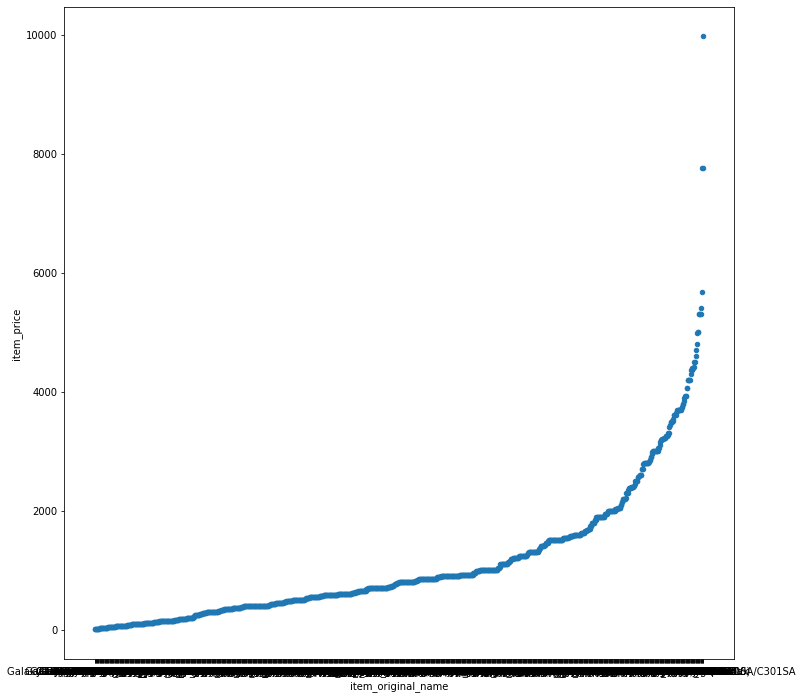

In [97]:
device_extracted_data_df.sort_values(by='item_price', inplace=True)
device_extracted_data_df.plot.scatter(x=0, y='item_price', figsize=(12, 12))

### 3.2 Prices Binning

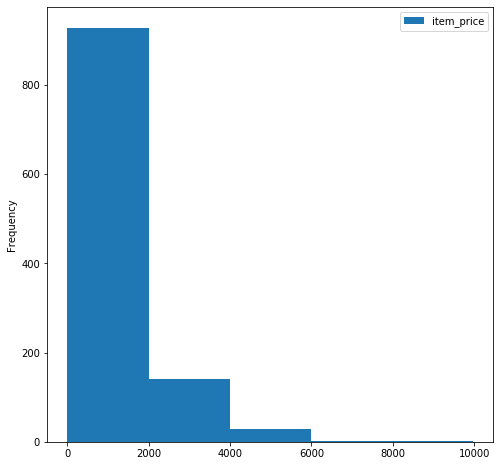

In [98]:
device_extracted_data_df.describe()
device_extracted_data_df.plot.hist(by=['item_price'], bins=5, figsize=(8, 8))


## 4 Price  Ranges
![Brazilian IBGE Salaries Ranges Research](./assets/ibge_brazilian_salary_ranges.jpg)

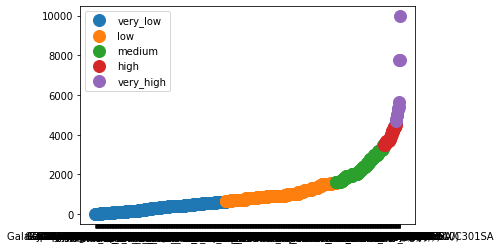

In [99]:
ibge_price_ranges_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
salaries_ibge_ranges = [(0, 1908), (1909, 2862), (2863, 5724), (5725, 3566)]
ibge_price_ranges = [0]
for i, salarie_range in enumerate(salaries_ibge_ranges):
    threshold_price = (salarie_range[0] + salarie_range[1])//3
    # As the values are so low, we have to increment them with the previous threshold
    threshold_price += ibge_price_ranges[i-1]
    ibge_price_ranges.append(threshold_price)
ibge_price_ranges.append(float('inf'))

device_extracted_data_df['ibge_price_range'] = pd.cut(device_extracted_data_df['item_price'], bins=ibge_price_ranges, labels=ibge_price_ranges_labels)
groups = device_extracted_data_df.groupby('ibge_price_range', sort=False)
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [100]:
device_extracted_data_df

,item_original_name,item_extracted_name,item_price,ibge_price_range
86,Breeze 7Y2241,CONECTOR MICRO USB TABLET AOC BREEZE AOC 7 7Y...,6.0,very_low
87,C103,CONECTOR MICRO USB TABLET AOC BREEZE AOC 7 7Y...,6.0,very_low
370,Galaxy Trend Plus GT-S7580,CELULAR SAMSUNG GALAXY TREND LITE GT-S7392L P...,15.0,very_low
369,Galaxy Trend Lite GT-S7392L DUOS,CELULAR SAMSUNG GALAXY TREND LITE GT-S7392L P...,15.0,very_low
117,E5006,SMARTPHONE LG E470F BRANCO APENAS PARTES PÇS....,18.0,very_low
...,...,...,...,...
270,Galaxy Note 4,SAMSUNG GALAXY NOTE10+ DUAL SIM 256 GB AURA B...,5400.0,very_high
715,Pixel 2 XL,"GOOGLE PIXEL 4 XL WHITE 64GB NOVINHO, NA CAIXA!",5674.0,very_high
1047,iPhone 11 Pro,APPLE IPHONE 11 PRO MAX DUAL SIM 64 GB CINZA-...,7759.0,very_high
1048,iPhone 11 Pro Max,APPLE IPHONE 11 PRO MAX DUAL SIM 64 GB CINZA-...,7759.0,very_high


### 4.1 Comparing with old price ranges

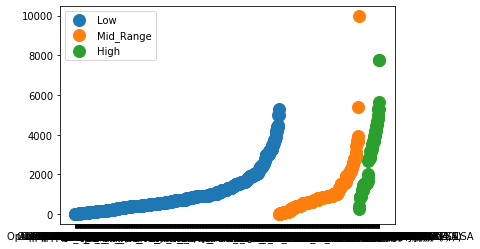

In [101]:
device_extracted_data_df = device_extracted_data_df.merge(right=devices_df, left_on='item_original_name', right_on='model_name', how='inner').drop(columns='model_name')
groups = device_extracted_data_df.groupby('old_price_range', sort=False)
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()